# Code Setup

In [180]:
library(ggplot2)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stargazer)
library(mgcv)
library(stats)
library(TSA)        # For cumulative periodogram
library(ggplot2)

# Data Setup

In [181]:
X <- read.table("provided material/data/cex4WindDataInterpolated.csv", sep=",",
header=TRUE, stringsAsFactors=FALSE)
X$t <- as.POSIXct(X$t, tz="UTC")

In [182]:
na_counts <- colSums(is.na(X))
knitr::kable(as.data.frame(na_counts), col.names = c("Missing Values"))
sum(!complete.cases(X))



|    | Missing Values|
|:---|--------------:|
|t   |              0|
|toy |              0|
|p   |            358|
|Ws1 |           1296|
|Wd1 |           1296|
|T1  |           1296|
|Ws2 |           1298|
|Wd2 |           1298|
|T2  |           1298|
|Ws3 |           1300|
|Wd3 |           1300|
|T3  |           1300|

[1] 1658

In [183]:
X_clean <- X[complete.cases(X), ]
sum(!complete.cases(X_clean))
X <- X_clean

[1] 0

In [184]:
head(X)
summary(X$p)

t                   toy   p     Ws1 Wd1   T1    Ws2 Wd2   T2    Ws3 Wd3  
1 1999-01-01 03:00:00 0.125 1.267 4.9 135.0 275.8 4.9 135.0 275.8 4.9 135.0
2 1999-01-01 04:00:00 0.167 1.515 5.0 126.9 275.8 5.0 126.9 275.8 5.0 126.9
3 1999-01-01 05:00:00 0.208 1.915 5.9 135.7 275.5 5.9 135.7 275.5 5.9 135.7
4 1999-01-01 06:00:00 0.250 1.613 5.3 146.6 275.0 5.3 146.6 275.0 5.3 146.6
5 1999-01-01 07:00:00 0.292 1.776 6.1 117.4 274.5 5.9 130.2 274.8 5.9 130.2
6 1999-01-01 08:00:00 0.333 1.998 7.6 133.4 273.9 7.6 133.4 273.9 7.3 142.8
  T3   
1 275.8
2 275.8
3 275.5
4 275.0
5 274.8
6 274.0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.283   2.827   4.919   7.855  20.300 

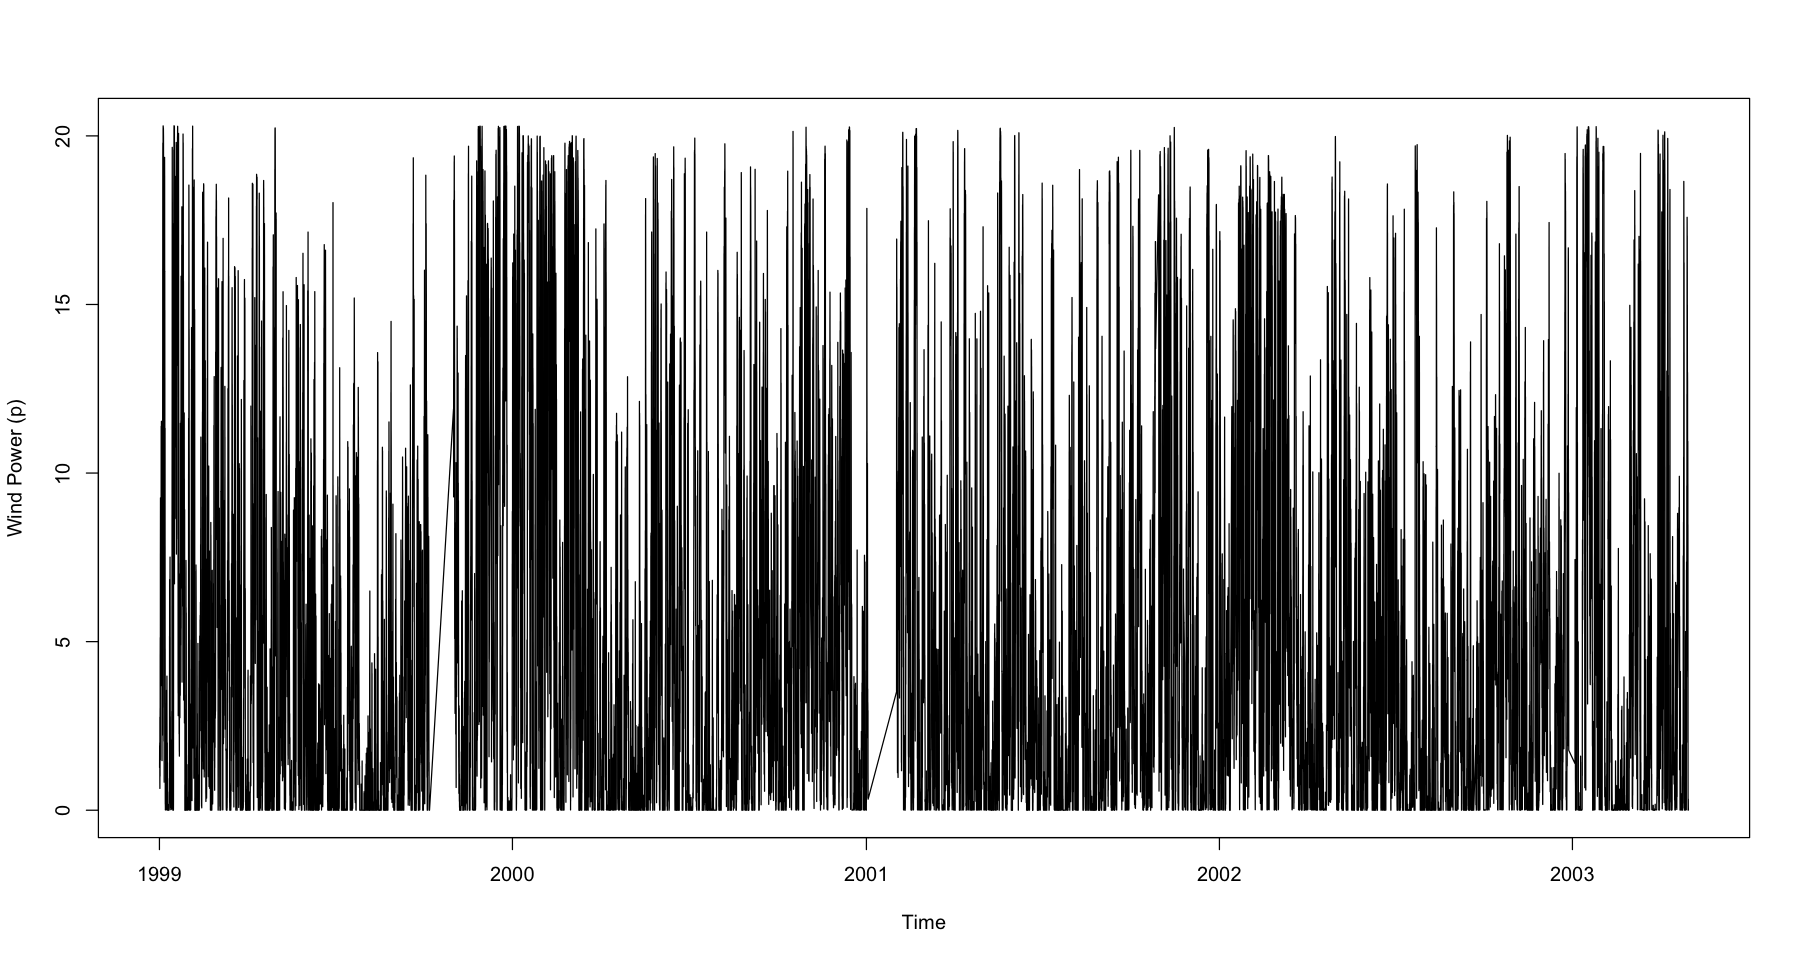

In [185]:
options(repr.plot.width=15, repr.plot.height=8)
plot(X$t, X$p, type="l", xlab="Time", ylab="Wind Power (p)")

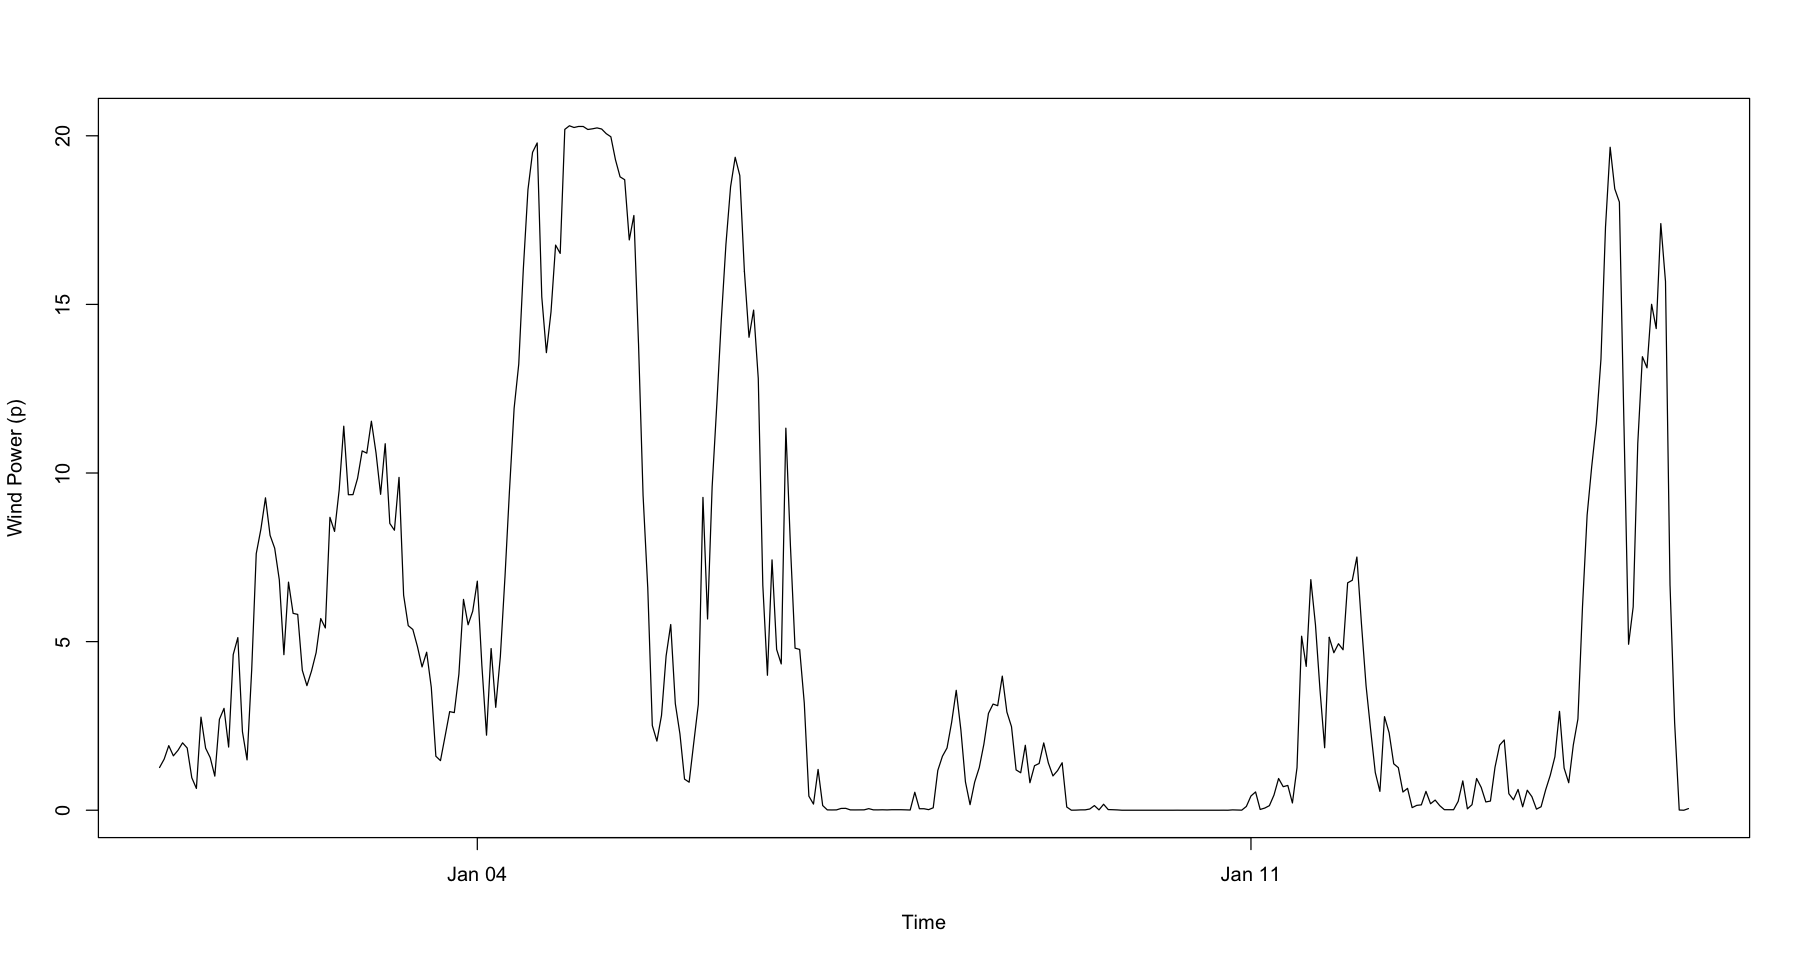

In [186]:
options(repr.plot.width=15, repr.plot.height=8)

# 1 year plot
X1 <- subset(X, t >= as.POSIXct("1999-01-01", tz="UTC") & t < as.POSIXct("1999-01-15", tz="UTC"))
plot(X1$t, X1$p, type="l", xlab="Time", ylab="Wind Power (p)")

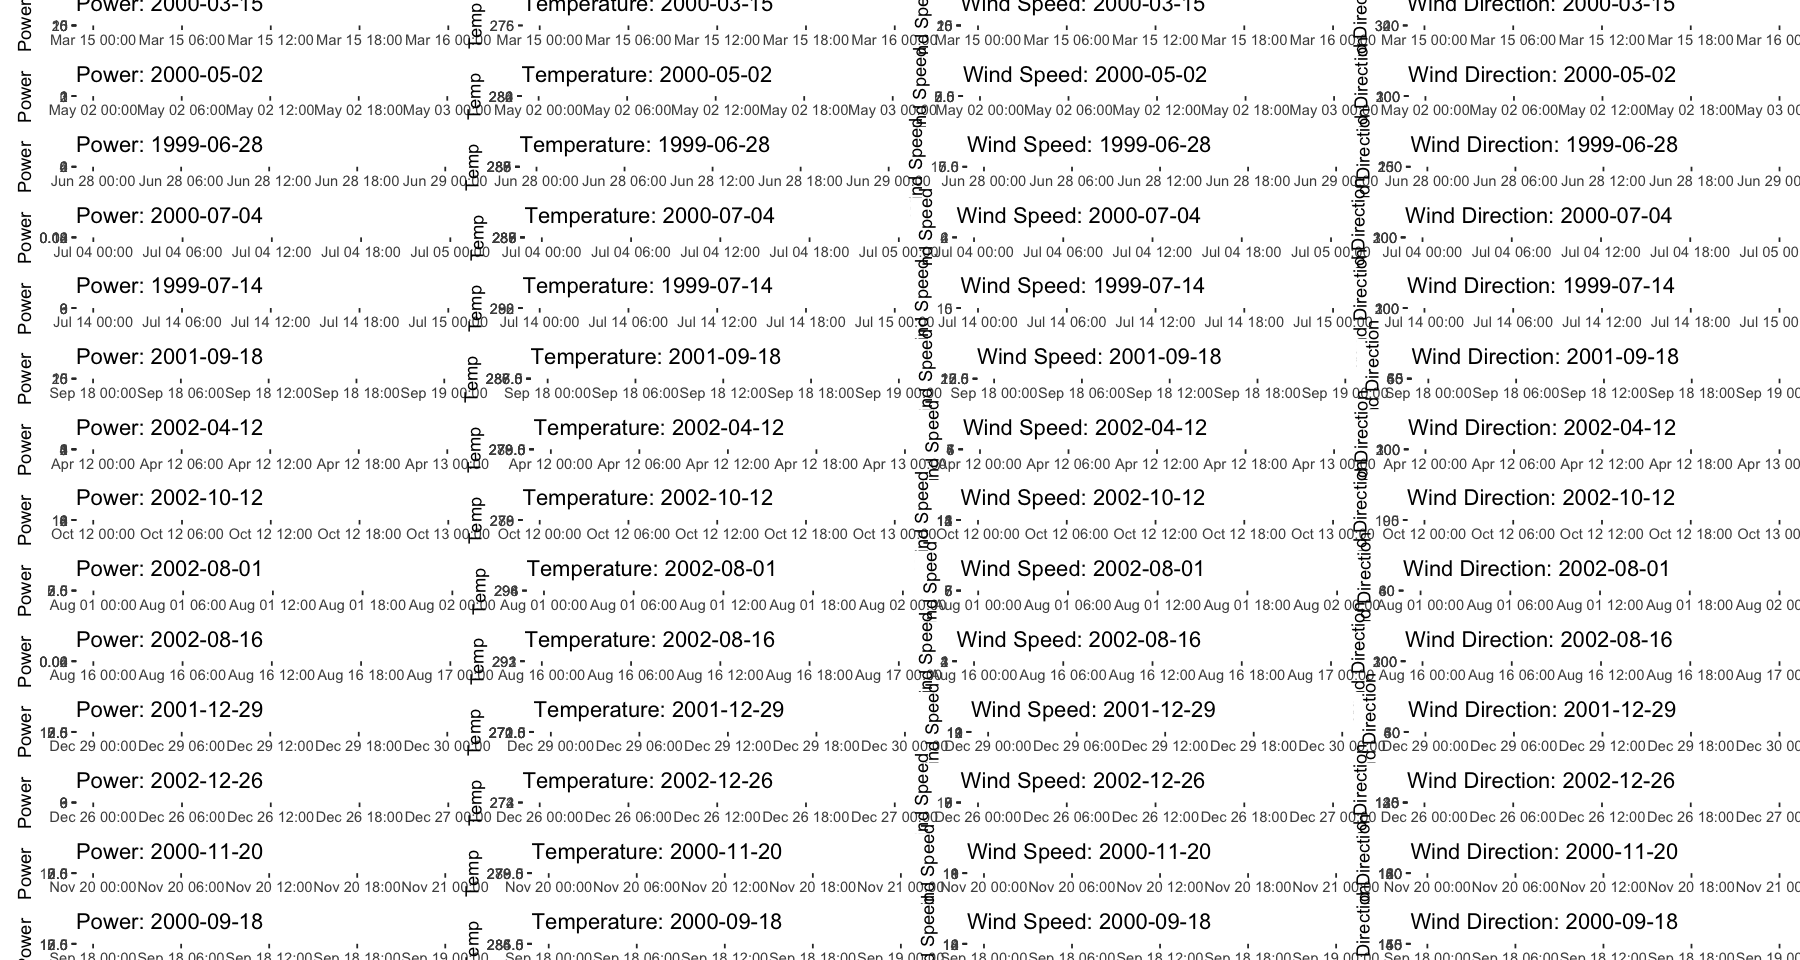

In [187]:
## --- Prepare date field
X$date <- as.Date(X$t)

## --- Select 3 random days
set.seed(123)
days3 <- sample(unique(X$date), 14)

## --- Function that builds a row of 3 plots for a given day
plot_day_row <- function(df_day, day_label) {

  p1 <- ggplot(df_day, aes(x = t, y = p)) +
    geom_line(color = "steelblue") +
    labs(title = paste("Power:", day_label), x = NULL, y = "Power")

  p2 <- ggplot(df_day, aes(x = t, y = T1)) +
    geom_line(color = "firebrick") +
    labs(title = paste("Temperature:", day_label), x = NULL, y = "Temp")

  p3 <- ggplot(df_day, aes(x = t, y = Ws1)) +
    geom_line(color = "darkgreen") +
    labs(title = paste("Wind Speed:", day_label), x = NULL, y = "Wind Speed")
  
  p4 <- ggplot(df_day, aes(x = t, y = Wd1)) +
    geom_line(color = "purple") +
    labs(title = paste("Wind Direction:", day_label), x = NULL, y = "Wind Direction")

  p1 + p2 + p3 + p4 + plot_layout(ncol = 4)
}

## --- Build the full 3-row layout
plots <- lapply(days3, function(d) {
  df_day <- X %>% filter(date == d)
  plot_day_row(df_day, as.character(d))
})

## Combine into rows
final_plot <- wrap_plots(plots, ncol = 1)

final_plot

Across all three days:
	•	When wind speed collapses, power collapses shortly after (Feb 19, Apr 7).
	•	When wind speed stays moderate, power fluctuates but doesn’t vanish (Jun 28).

Temperature moves smoothly, slowly, independently of power or wind speed.

This is expected:
	•	Air density changes with temperature, but the effect is small compared to wind speed.
	•	Nothing in the plots suggests temperature contributes any predictive power on hourly scales.


Model implications

The system has thresholds: when wind drops below ~4 m/s, power always goes to zero. Threshold models, logistic activation of nonlinear terms, or a learned power curve would help.

In [188]:
# Pure autoregressive model
model.ar <- arima(x = X$p, order = c(4,0,0))

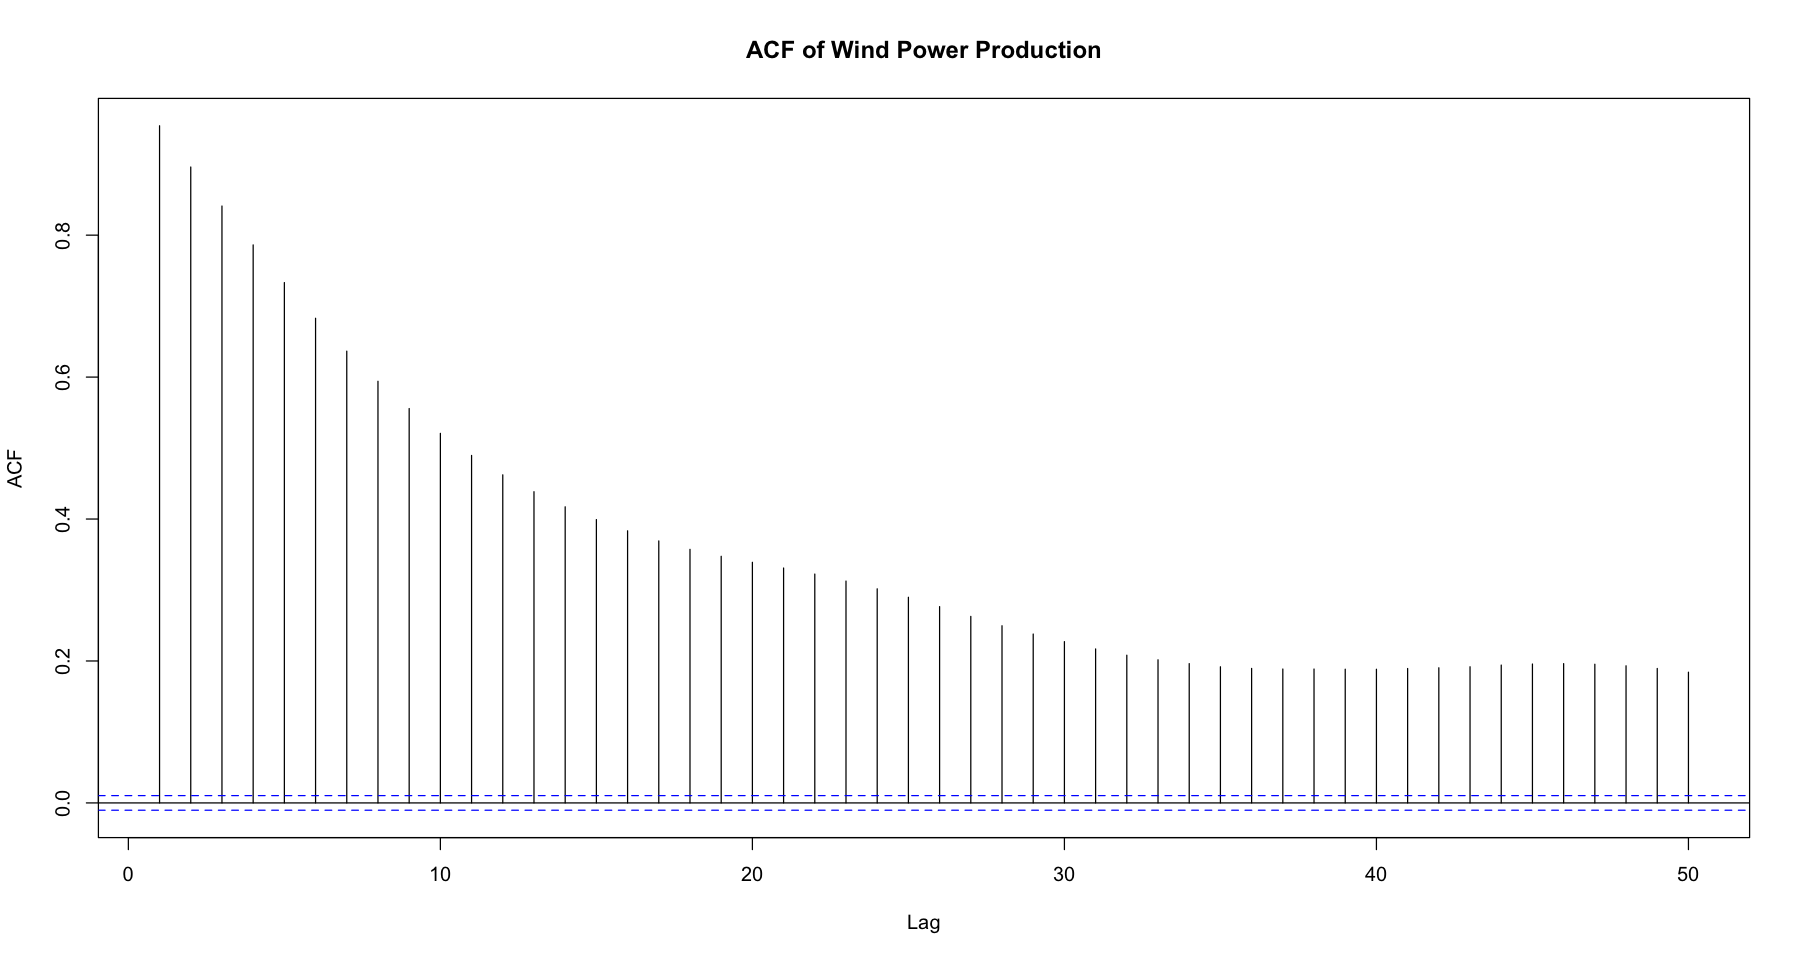

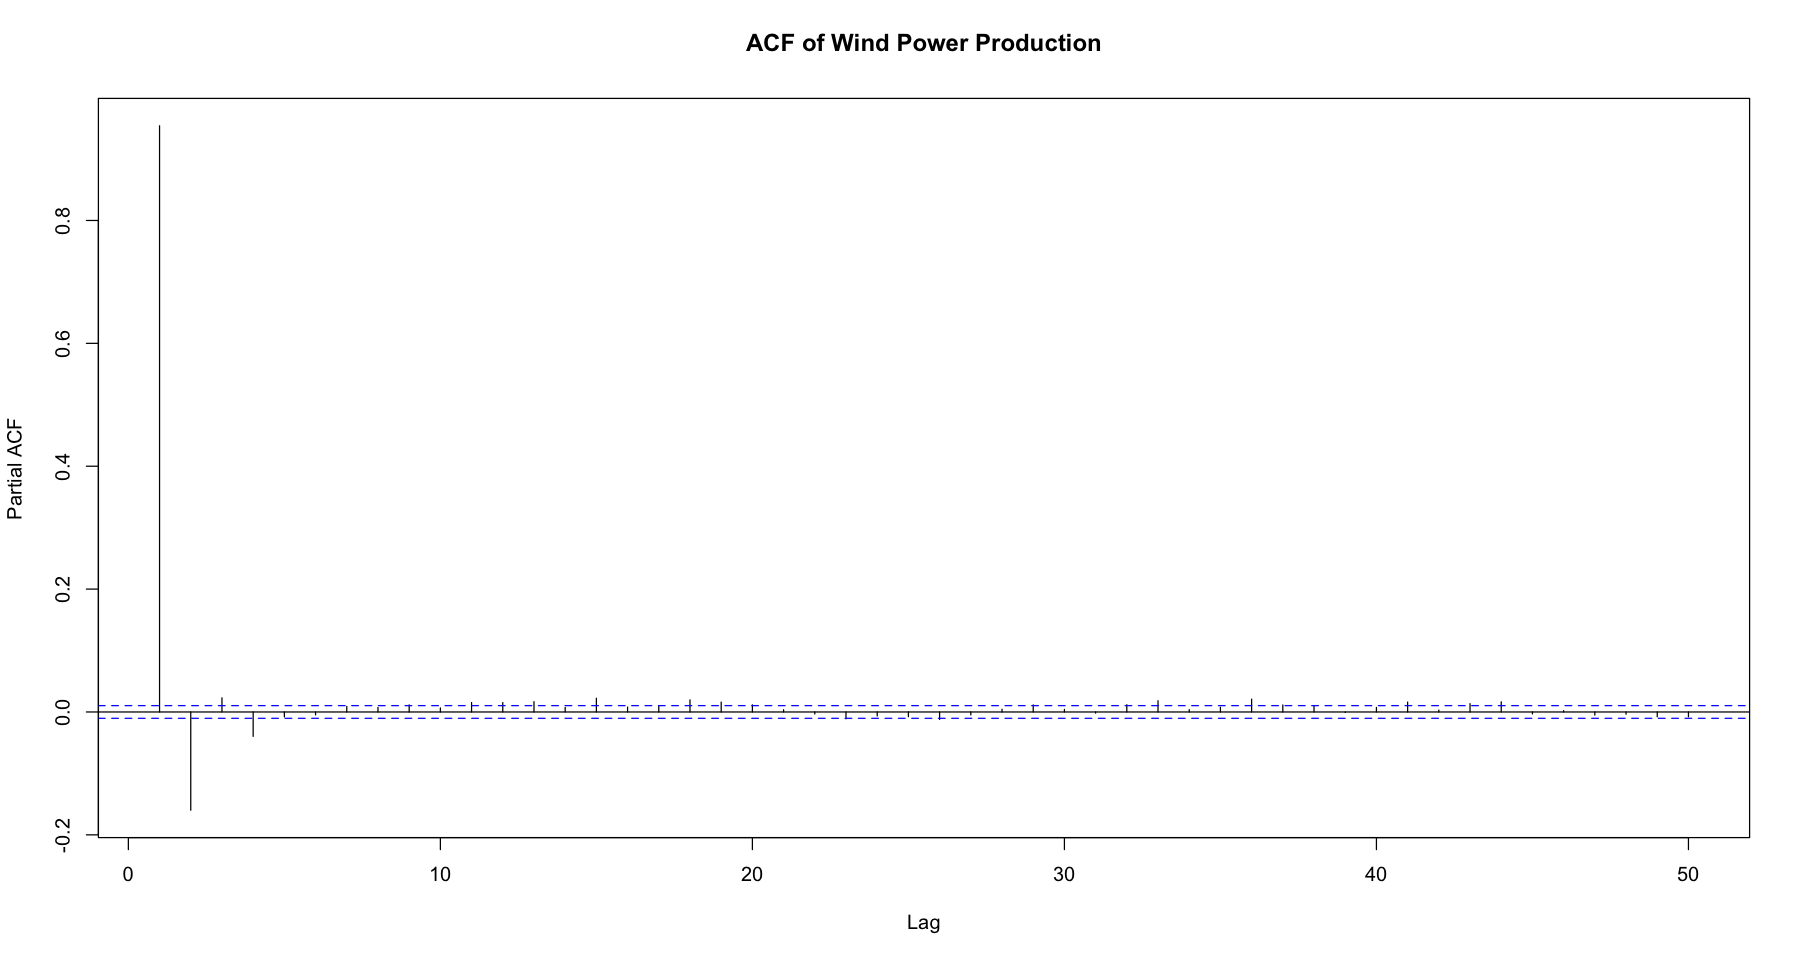

In [189]:
acf(X$p, lag.max = 50, main = "ACF of Wind Power Production")
pacf(X$p, lag.max = 50, main = "ACF of Wind Power Production")

In [190]:
stargazer(model.ar, type = "text")


                      Dependent variable:    
                  ---------------------------
                                             
---------------------------------------------
ar1                        1.111***          
                            (0.005)          
                                             
ar2                        -0.193***         
                            (0.008)          
                                             
ar3                        0.067***          
                            (0.008)          
                                             
ar4                        -0.040***         
                            (0.005)          
                                             
intercept                  4.919***          
                            (0.158)          
                                             
---------------------------------------------
Observations                36,283           
Log Likelihood            -69,046


                      Dependent variable:    
                  ---------------------------
                                             
---------------------------------------------
ar1                        1.114***          
                            (0.007)          
                                             
ar2                        -0.185***         
                            (0.011)          
                                             
ar3                        0.051***          
                            (0.011)          
                                             
ar4                        -0.026**          
                            (0.011)          
                                             
ar5                          0.003           
                            (0.011)          
                                             
ar6                        -0.025**          
                            (0.011)          
                                 

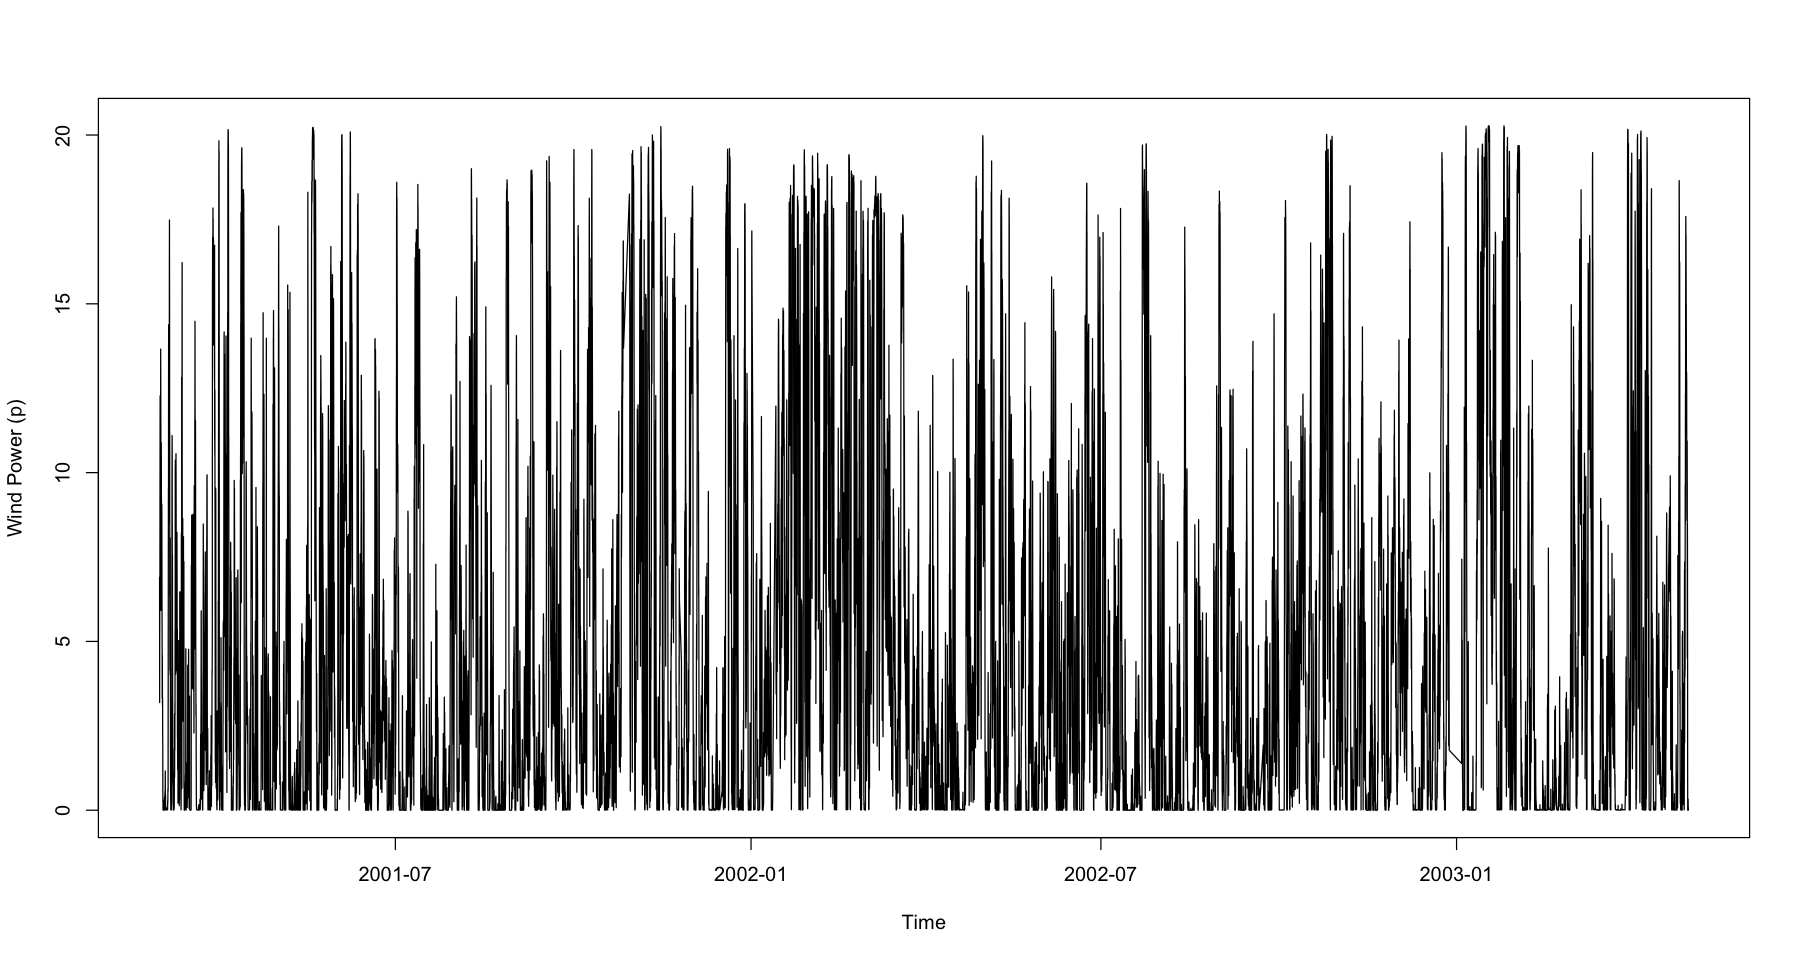

In [191]:
options(repr.plot.width=15, repr.plot.height=8)

# 1 year plot
X2 <- subset(X, t >= as.POSIXct("2001-03-01", tz="UTC"))
plot(X2$t, X2$p, type="l", xlab="Time", ylab="Wind Power (p)")
model.ar_one_year <- arima(x = X2$p, order = c(10,0,0))
stargazer(model.ar_one_year, type = "text")

From the ACF plot and The system clearly retains influence from the previous 4 hours. If the wind drops suddenly, the rotor inertia and atmospheric mixing don’t collapse instantly.

Why AR(6) appears significant

This is typical for wind series:
The ACF is smooth and slow, so Yule-Walker or ML estimation will find lingering significance for lags 5–7 even when they’re small.

It does not mean AR(6) is a “true” structural lag.
It means atmospheric persistence still matters at ~6 hours, but weakly.


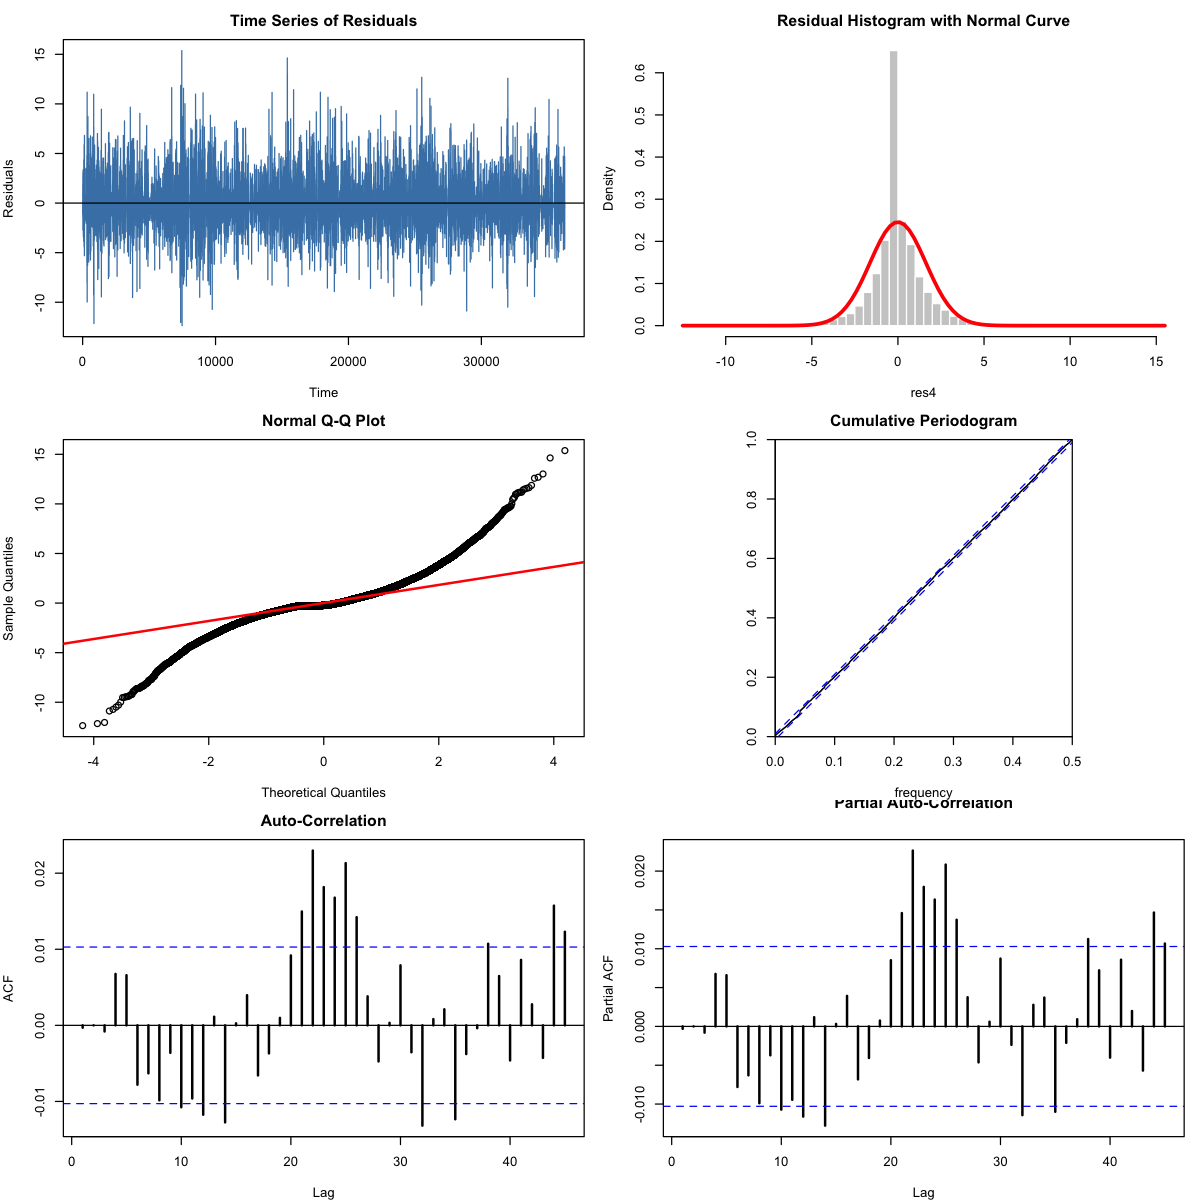

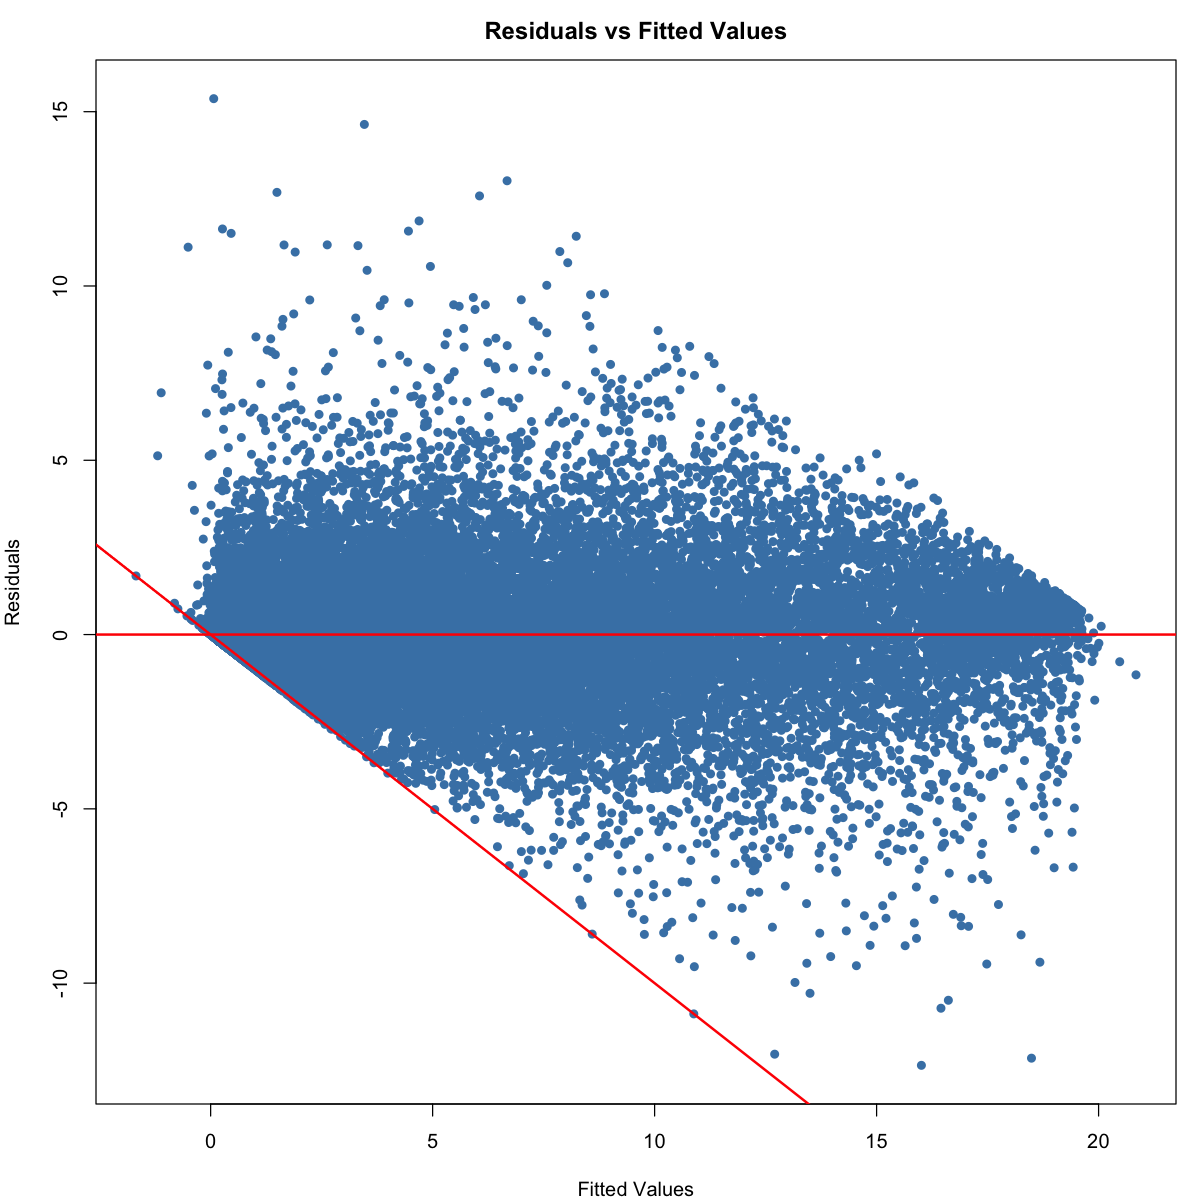

In [192]:
options(repr.plot.width=10, repr.plot.height=10)

m <- model.ar

## --- Compute residuals ---
res4 <- na.omit(residuals(m))

## --- 6 panel layout ---
par(mfrow = c(3, 2), mar = c(4,4,2.5,1))

## 1) Time Series of Residuals
plot(res4, type="l", col="steelblue",
     main="Time Series of Residuals", xlab="Time", ylab="Residuals")
abline(h=0, col="black")

## 2) Histogram
hist(res4, breaks = 40, freq = FALSE,
     col = "gray80", border = "white",
     main = "Residual Histogram with Normal Curve")

curve(dnorm(x, mean = mean(res4), sd = sd(res4)),
      col = "red", lwd = 3, add = TRUE)

## 3) Normal Q–Q Plot
qqnorm(res4, main="Normal Q-Q Plot")
qqline(res4, col="red", lwd=2)

## 4) Cumulative Periodogram
cpgram(res4, main="Cumulative Periodogram")

## 5) ACF plot
acf(res4, main="Auto-Correlation", lwd=2)

## 6) PACF plot
pacf(res4, main="Partial Auto-Correlation", lwd=2)

par(mfrow = c(1,1))


plot(fitted(m), m$residuals,
     xlab="Fitted Values", ylab="Residuals",
     main="Residuals vs Fitted Values",
     col="steelblue", pch=16)
abline(a = 0, b = -1, col = "red", lwd = 2)  # e = -ŷ lower bound "Because physics is bullying your regression."
abline(a = 0, b = 0, col = "red", lwd = 2)  # e = -ŷ lower bound "Because physics is bullying your regression."

The vertical spread is evidence of heteroscedasticity.

The residuals bending systematically, the clear asymmetry, and the lack of no random cloud around zero is evidence of non-linearity that the AR(4) model fails to capture. The AR model cannot capture the turbine power curve (nonlinear Ws → P mapping), cut-in / cut-out thresholds, directional dependence, seasonal roughness and saturation region.

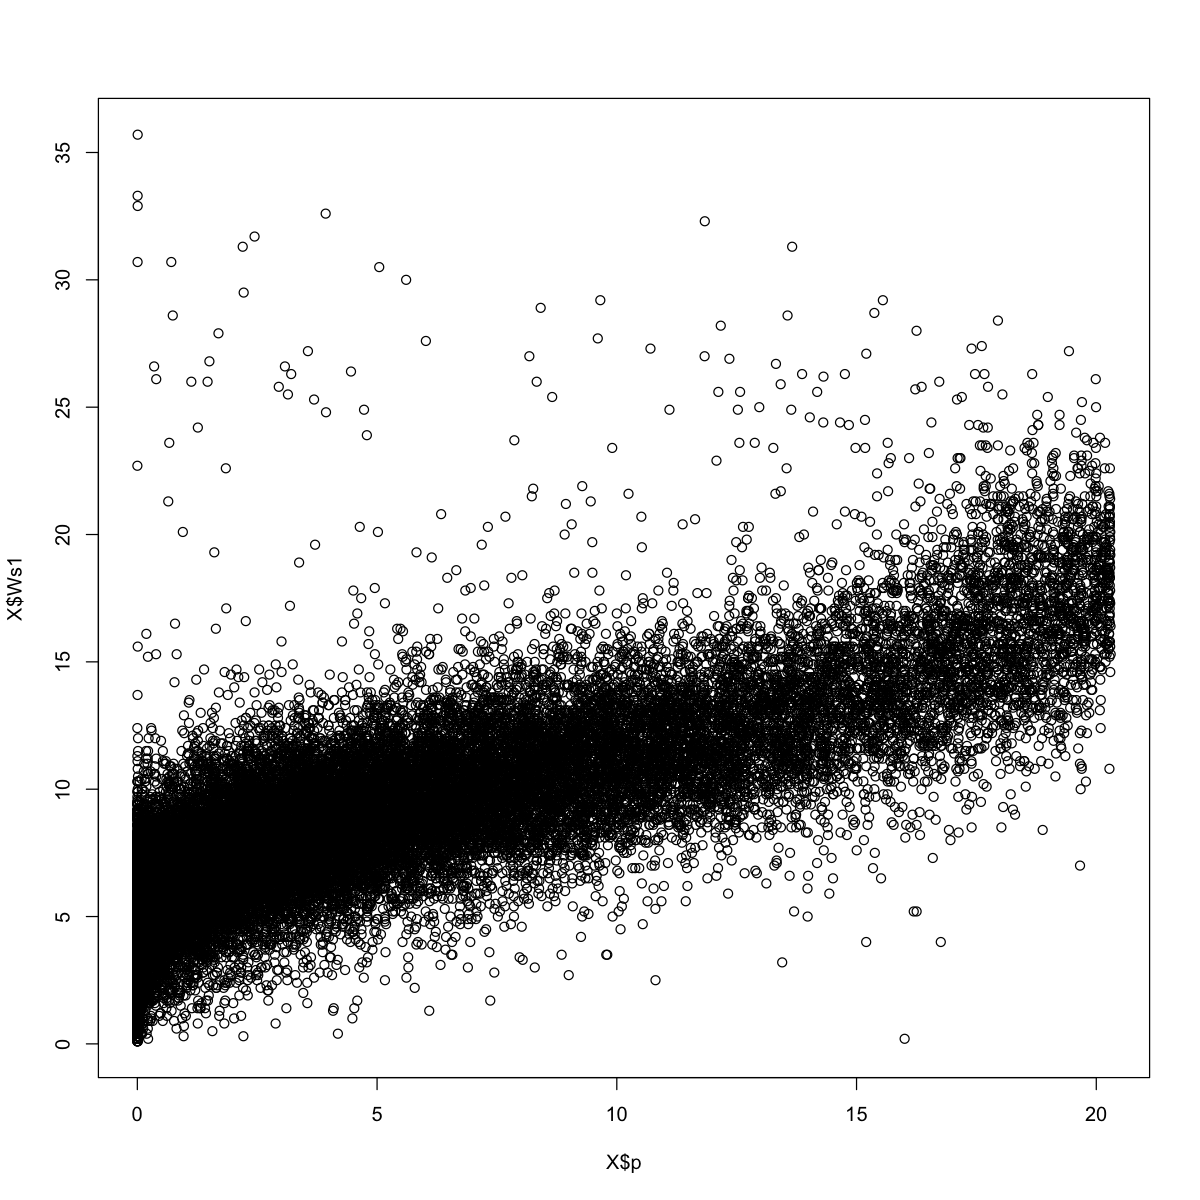

In [193]:
plot(X$p, X$Ws1)

In [194]:
df <- X
df$Wd1_rad <- df$Wd1 * pi/180 # convert degrees to radians since trigonometric functions in R use radians

mod_cont <- lm(
  p ~ 
    Ws1 + I(Ws1^2) +
    sin(Wd1_rad) + cos(Wd1_rad) +
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad),
  data = df
)
summary(mod_cont)


Call:
lm(formula = p ~ Ws1 + I(Ws1^2) + sin(Wd1_rad) + cos(Wd1_rad) + 
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.643  -1.866  -0.244   1.600  20.052 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.7009902  0.0597104 -61.982  < 2e-16 ***
Ws1               0.9638727  0.0127895  75.364  < 2e-16 ***
I(Ws1^2)          0.0050702  0.0006378   7.950 1.92e-15 ***
sin(Wd1_rad)     -0.3867389  0.0530504  -7.290 3.16e-13 ***
cos(Wd1_rad)      0.5662118  0.0543524  10.417  < 2e-16 ***
Ws1:sin(Wd1_rad)  0.0016107  0.0059927   0.269    0.788    
Ws1:cos(Wd1_rad) -0.1278432  0.0061387 -20.826  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.043 on 36276 degrees of freedom
Multiple R-squared:  0.6935,	Adjusted R-squared:  0.6934 
F-statistic: 1.368e+04 on 6 and 36276 DF,  p-value: < 2.2e-16


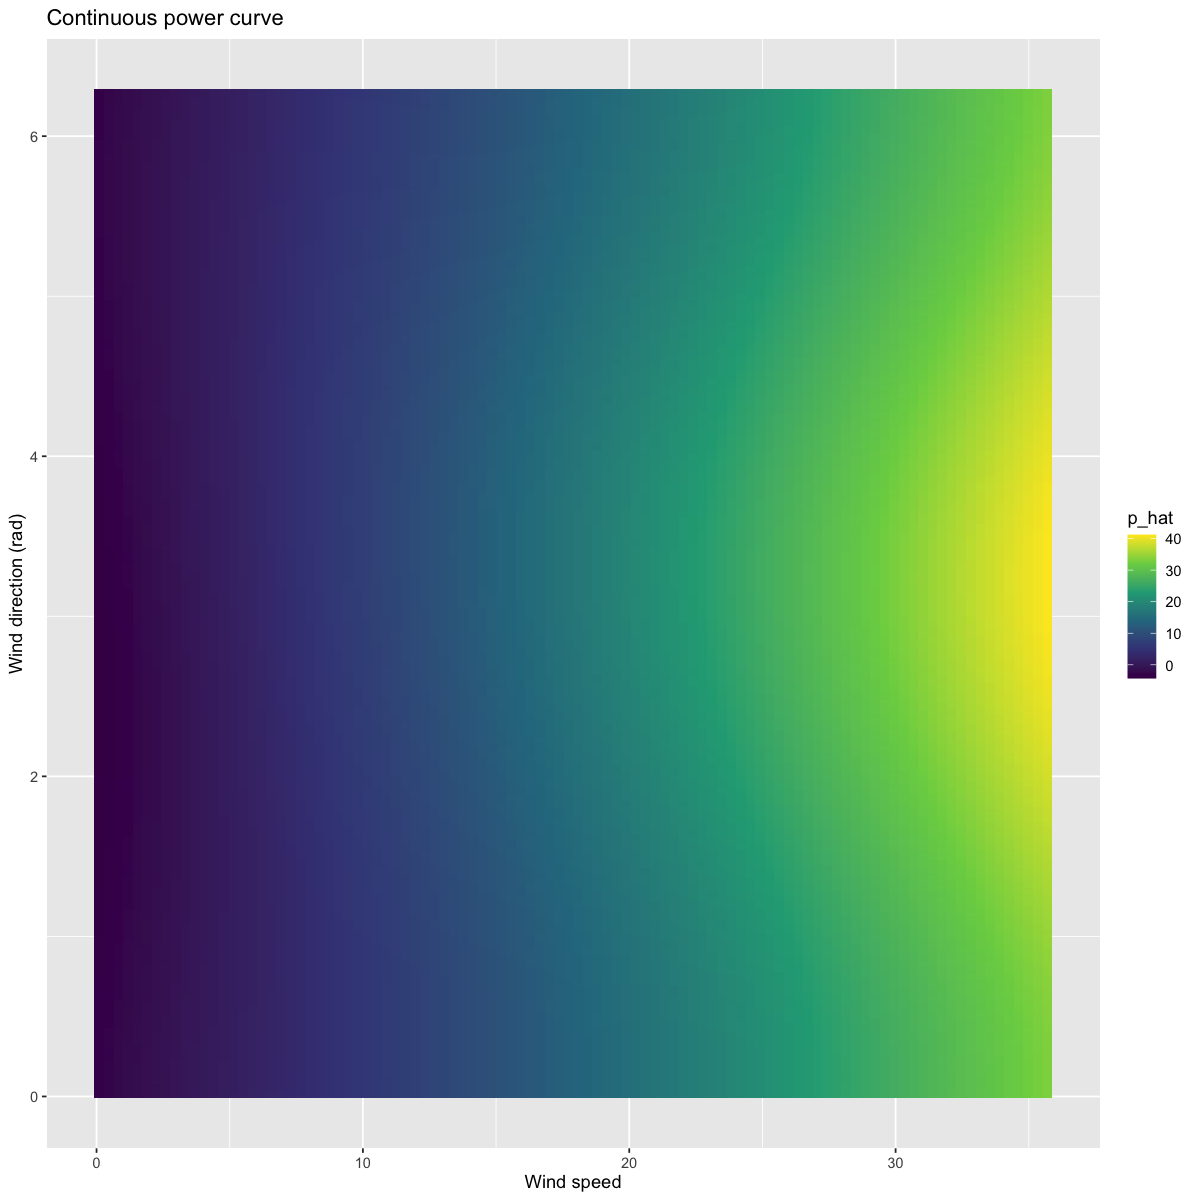

In [195]:
ws_grid <- seq(min(df$Ws1), max(df$Ws1), length.out = 100)
wd_grid <- seq(0, 2*pi, length.out = 360)

grid <- expand.grid(Ws1 = ws_grid, Wd1_rad = wd_grid)

grid$p_hat <- predict(mod_cont, newdata = grid)

library(ggplot2)

ggplot(grid, aes(Ws1, Wd1_rad, fill = p_hat)) +
  geom_tile() +
  scale_fill_viridis_c() +
  labs(title = "Continuous power curve",
       x = "Wind speed",
       y = "Wind direction (rad)")

In [196]:
df$Wd1_rad <- df$Wd1 * pi/180

mod <- lm(
  p ~ 
    Ws1 + I(Ws1^2) + I(Ws1^3) +
    sin(Wd1_rad) + cos(Wd1_rad) +
    sin(2*Wd1_rad) + cos(2*Wd1_rad) +
    Ws1:sin(Wd1_rad) + Ws1:cos(Wd1_rad),
  data = df
)

summary(mod)


Call:
lm(formula = p ~ Ws1 + I(Ws1^2) + I(Ws1^3) + sin(Wd1_rad) + cos(Wd1_rad) + 
    sin(2 * Wd1_rad) + cos(2 * Wd1_rad) + Ws1:sin(Wd1_rad) + 
    Ws1:cos(Wd1_rad), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.4283  -1.3907  -0.2111   1.1155  30.1994 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.257e+00  7.650e-02  16.429  < 2e-16 ***
Ws1              -9.809e-01  2.444e-02 -40.134  < 2e-16 ***
I(Ws1^2)          2.056e-01  2.275e-03  90.359  < 2e-16 ***
I(Ws1^3)         -5.667e-03  6.193e-05 -91.503  < 2e-16 ***
sin(Wd1_rad)     -1.203e-01  4.737e-02  -2.540   0.0111 *  
cos(Wd1_rad)      1.787e-02  4.884e-02   0.366   0.7145    
sin(2 * Wd1_rad)  4.141e-01  2.084e-02  19.870  < 2e-16 ***
cos(2 * Wd1_rad)  5.411e-01  2.133e-02  25.370  < 2e-16 ***
Ws1:sin(Wd1_rad) -2.183e-02  5.368e-03  -4.066  4.8e-05 ***
Ws1:cos(Wd1_rad) -4.867e-02  5.580e-03  -8.722  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01


Recursive Least Squares is an adaptive version of ordinary least squares where the parameter vector is updated sequentially each time new data arrive. A forgetting factor assigns decreasing weight to older observations, allowing the model to track time-varying dynamics. The RLS recursion is mathematically equivalent to a Kalman filter applied to a linear state-space model with the parameter vector as the state. This makes RLS a natural choice for modelling and forecasting non-stationary systems such as wind-power production.


Forward-filling or using AR predictions to fill 6-day gaps in power data is not appropriate. Wind power is highly variable, and AR models only describe short-range temporal dependence; they cannot generate realistic multi-day forecasts. Filling these long gaps would introduce artificial autocorrelation and contaminate the model estimation. The correct approach in this project is simply to remove the missing p values and estimate the AR and regression models on the available data. This also aligns with the course methodology, where missing measurements are not imputed but ignored in the estimation.

# Final

In [197]:
# helpers


rmse <- function(e) sqrt(mean(e^2, na.rm = TRUE))

plot_residual_diagnostics <- function(m,
                                      model_name = "Model",
                                      width = 10,
                                      height = 10) {

  # Set plot size (works in Jupyter / RStudio Viewer)
  options(repr.plot.width = width, repr.plot.height = height)

  ## --- Compute residuals ---
  res <- na.omit(residuals(m))
  fit <- fitted(m)

  ## --- 6 panel layout ---
  par(mfrow = c(3, 2), mar = c(4, 4, 2.5, 1))

  ## 1) Time Series of Residuals
  plot(res, type = "l", col = "steelblue",
       main = paste("Residuals vs Time –", model_name),
       xlab = "Time", ylab = "Residuals")
  abline(h = 0, col = "black")

  ## 2) Histogram + Normal curve
  hist(res, breaks = 40, freq = FALSE,
       col = "gray80", border = "white",
       main = paste("Residual Histogram –", model_name),
       xlab = "Residuals")

  curve(dnorm(x, mean = mean(res), sd = sd(res)),
        col = "red", lwd = 3, add = TRUE)

  ## 3) Normal Q–Q Plot
  qqnorm(res, main = paste("Normal Q–Q Plot –", model_name))
  qqline(res, col = "red", lwd = 2)

  ## 4) Cumulative Periodogram
  cpgram(res, main = paste("Cumulative Periodogram –", model_name))

  ## 5) ACF
  acf(res, main = paste("ACF of Residuals –", model_name), lwd = 2)

  ## 6) PACF
  pacf(res, main = paste("PACF of Residuals –", model_name), lwd = 2)

  par(mfrow = c(1, 1))

  ## --- Residuals vs Fitted ---
  plot(fit, residuals(m),
       xlab = "Fitted Values",
       ylab = "Residuals",
       main = paste("Residuals vs Fitted –", model_name),
       col = "steelblue", pch = 16)

  abline(h = 0, col = "red", lwd = 2)
  abline(a = 0, b = -1, col = "red", lwd = 2)  # physics lower bound

  invisible(NULL)
}

# The scatterplot shows saturation after some wind speed, we encode
# encode a hard “rated-speed” regime without changing estimation
apply_power_curve_cap <- function(pred, Ws, P_rated = 20.3, v_rated = 16.5) {
  pred2 <- pred
  pred2[Ws >= v_rated] <- P_rated
  pred2 <- pmax(0, pred2)
  pred2
}

make_horizon_df <- function(X, h = 1) {
  stopifnot(h %in% c(1,2,3))
  df <- X

  # choose forecast inputs corresponding to horizon
  ws <- df[[paste0("Ws", h)]]
  wd <- df[[paste0("Wd", h)]]
  tt <- df[[paste0("T",  h)]]

  wd_rad <- wd * pi/180

  # target is p at t+h; regressors are "available at time t"
  # (i.e., Ws_h etc in the same row). This is the standard supervised setup.
  y <- dplyr::lead(df$p, h)

  out <- data.frame(
    t   = df$t,
    y   = y,
    toy = df$toy,
    Ws  = ws,
    Wd  = wd,
    Wd_rad = wd_rad,
    T   = tt
  )

  # drop last h rows (y becomes NA)
  out <- out[!is.na(out$y), ]
  out
}

## Build design matrix (keep it simple + close to your static model)
## You can add/remove terms, but keep it linear-in-parameters.
make_Xmat <- function(d) {
  with(d, {
    cbind(
      1,
      Ws,
      Ws^2,
      Ws^3,
      sin(Wd_rad), cos(Wd_rad),
      sin(2*Wd_rad), cos(2*Wd_rad),
      Ws*sin(Wd_rad), Ws*cos(Wd_rad),
      # Optional: seasonality proxy (toy). Keep it minimal:
      sin(2*pi*toy), cos(2*pi*toy)
      # Optional: temperature:
    #   T
    )
  })
}

sigmoid <- function(z) 1 / (1 + exp(-z))

## ============================================================
## CRPS for a Normal predictive distribution N(mu, sd^2)
## ============================================================
crps_norm <- function(y, mu, sd) {
  sd <- pmax(sd, 1e-8)  # guard
  z  <- (y - mu) / sd
  sd * ( z * (2*pnorm(z) - 1) + 2*dnorm(z) - 1/sqrt(pi) )
}

crps_mean <- function(y, mu, sd) mean(crps_norm(y, mu, sd), na.rm = TRUE)

In [198]:
# Takes around 4mn to run for refit_every = 50, set to 1000 momentarily if you do not care about AR baselines. 
# Ideally should be at 1 but it could take like 1h.
refit_every = 24


## ============================================================
## 1) RLS (lecture form): beta_t = beta_{t-1} + K_t e_t, forgetting lambda
## ============================================================
rls_online <- function(Xmat, y, lambda = 0.99, beta0 = NULL, P0 = NULL) {
  n <- nrow(Xmat)
  k <- ncol(Xmat)

  if (is.null(beta0)) beta0 <- rep(0, k)
  if (is.null(P0))    P0 <- diag(1e6, k)  # diffuse prior (large uncertainty)

  beta <- beta0
  P    <- P0

  yhat  <- rep(NA_real_, n)
  err   <- rep(NA_real_, n)
  betas <- matrix(NA_real_, nrow = n, ncol = k)

  for (t in 1:n) {
    xt <- matrix(Xmat[t, ], ncol = 1)

    # 1) predict
    yhat[t] <- as.numeric(t(Xmat[t, ]) %*% beta)
    err[t]  <- y[t] - yhat[t]

    # 2) gain
    denom <- as.numeric(lambda + t(xt) %*% P %*% xt)
    Kt    <- as.numeric(1/denom) * (P %*% xt)

    # 3) update beta
    beta  <- beta + as.numeric(err[t]) * as.vector(Kt)

    # 4) update covariance
    P     <- (1/lambda) * (P - Kt %*% t(xt) %*% P)

    betas[t, ] <- beta
  }

  list(yhat = yhat, err = err, betas = betas)
}


## ============================================================
## 1a) Fixed-origin AR forecast (baseline)
## ============================================================

##
# ar_hstep_fixed_origin <- function(p, n0, h = 1, p_ar = 4) {
#   fit <- arima(p[1:n0], order = c(p_ar,0,0), include.mean = TRUE)
#   # multi-step forecast from end of training
#   pred_path <- predict(fit, n.ahead = (length(p) - n0) + h)$pred
#   ar_pred <- rep(NA_real_, length(p))
#   for (t in (n0 + 1):length(p)) {
#     ar_pred[t] <- pred_path[(t - n0) + h]  # forecast made at origin n0
#   }
#   ar_pred
# }

ar_hstep_rolling_dist <- function(p, n0, h = 1, p_ar = 4, refit_every = 24) {
  n <- length(p)
  mu <- rep(NA_real_, n)
  sd <- rep(NA_real_, n)

  fit_t <- arima(p[1:n0], order = c(p_ar, 0, 0), include.mean = TRUE)

  for (t in (n0 + 1):n) {

    if (((t - (n0 + 1)) %% refit_every) == 0) {
      fit_t <- arima(p[1:(t-1)], order = c(p_ar, 0, 0), include.mean = TRUE)
    }

    pr <- predict(fit_t, n.ahead = h)
    mu[t] <- as.numeric(pr$pred[h])
    sd[t] <- as.numeric(pr$se[h])   # THIS is what makes CRPS meaningful
  }

  list(mu = mu, sd = sd)
}


## ============================================================
## EKF power curve: also return predictive sd_t = sqrt(S_t)
## ============================================================
ekf_powercurve <- function(Ws, y, theta0, P0,
                           q = c(1e-4, 1e-4, 1e-4),
                           r = NULL,
                           P_rated = 20.3) {

  n <- length(y)
  stopifnot(length(Ws) == n, length(theta0) == 3)

  if (is.null(r)) r <- var(y, na.rm = TRUE) * 0.1

  Q <- diag(q, 3)
  R <- as.numeric(r)
  I <- diag(1, 3)

  theta <- as.numeric(theta0)
  P <- P0

  yhat  <- rep(NA_real_, n)
  err   <- rep(NA_real_, n)
  sdhat <- rep(NA_real_, n)     # <--- ADD
  thetas <- matrix(NA_real_, n, 3)

  for (t in 1:n) {
    v50 <- theta[1]
    k   <- max(theta[2], 1e-3)
    b   <- theta[3]

    theta_pred <- theta
    P_pred <- P + Q

    u <- (Ws[t] - v50) / k
    a <- sigmoid(u)
    y_pred <- P_rated * a + b

    da_du <- a * (1 - a)
    dy_dv50 <- P_rated * da_du * (-1 / k)
    dy_dk   <- P_rated * da_du * (-(Ws[t] - v50) / (k^2))
    dy_db   <- 1

    H <- matrix(c(dy_dv50, dy_dk, dy_db), nrow = 1)

    S <- as.numeric(H %*% P_pred %*% t(H) + R)
    K <- (P_pred %*% t(H)) / S

    innov <- y[t] - y_pred
    theta <- theta_pred + as.vector(K) * innov
    P <- (I - K %*% H) %*% P_pred

    yhat[t]  <- y_pred
    err[t]   <- innov
    sdhat[t] <- sqrt(pmax(S, 1e-12))   # <--- ADD
    thetas[t, ] <- theta
  }

  colnames(thetas) <- c("v50", "k", "b")
  list(yhat = yhat, err = err, sd = sdhat, thetas = thetas, q = q, r = R)
}

## ============================================================
## 2) Train/validation split + comparison (OLS vs RLS), per horizon
## ============================================================

fit_compare_horizon <- function(X, h = 1, train_frac = 0.7, lambda = 0.99, ar_order = 4) {
  d  <- make_horizon_df(X, h)
  Xm <- make_Xmat(d)
  y  <- d$y

  n  <- nrow(Xm)
  n0 <- floor(train_frac * n)
  idx_val <- (n0 + 1):n

  p_full <- X$p

  ## --- AR (mean + sd) on original p ---
  ar1_out <- ar_hstep_rolling_dist(p_full, n0 = n0, h = h, p_ar = 1,       refit_every = refit_every)
  arp_out <- ar_hstep_rolling_dist(p_full, n0 = n0, h = h, p_ar = ar_order, refit_every = refit_every)

  ar1_mu <- ar1_out$mu[1:(length(p_full) - h)]
  ar1_sd <- ar1_out$sd[1:(length(p_full) - h)]
  arp_mu <- arp_out$mu[1:(length(p_full) - h)]
  arp_sd <- arp_out$sd[1:(length(p_full) - h)]

  ## --- OLS ---
  ols_fit   <- lm(y[1:n0] ~ Xm[1:n0, ] - 1)
  beta0_ols <- coef(ols_fit)
  ols_pred  <- as.numeric(Xm %*% beta0_ols)

  ## shared covariance init from TRAIN
  P0_train <- solve(t(Xm[1:n0, ]) %*% Xm[1:n0, ] + diag(1e-6, ncol(Xm)))

  ## --- EKF (on validation only) ---
  Ws_val <- d$Ws
  theta0 <- c(
    v50 = median(Ws_val[1:n0], na.rm=TRUE),
    k   = sd(Ws_val[1:n0], na.rm=TRUE),
    b   = mean(y[1:n0], na.rm=TRUE) * 0.05
  )
  P0_theta <- diag(c(1,1,1)) * 10
  r_hat <- var(y[1:n0] - ols_pred[1:n0], na.rm = TRUE)

  ekf <- ekf_powercurve(
    Ws = Ws_val[idx_val],
    y  = y[idx_val],
    theta0 = theta0,
    P0 = P0_theta,
    q = c(1e-3, 1e-3, 1e-3),
    r = r_hat,
    P_rated = 20.3
  )

  ekf_pred <- rep(NA_real_, n); ekf_pred[idx_val] <- ekf$yhat
  ekf_sd   <- rep(NA_real_, n); ekf_sd[idx_val]   <- ekf$sd

  ## --- RLS ---
  rls <- rls_online(
    Xmat   = Xm[idx_val, , drop=FALSE],
    y      = y[idx_val],
    lambda = lambda,
    beta0  = beta0_ols,
    P0     = P0_train
  )
  rls_pred <- rep(NA_real_, n); rls_pred[idx_val] <- rls$yhat

  ## --- power cap (means only; keep sd as-is) ---
  P_rated <- 20.3
  v_rated <- 16.5
  Ws_cap  <- d$Ws

  ar1_mu   <- apply_power_curve_cap(ar1_mu,   Ws_cap, P_rated, v_rated)
  arp_mu   <- apply_power_curve_cap(arp_mu,   Ws_cap, P_rated, v_rated)
  ols_pred <- apply_power_curve_cap(ols_pred, Ws_cap, P_rated, v_rated)
  rls_pred <- apply_power_curve_cap(rls_pred, Ws_cap, P_rated, v_rated)
  # ekf_pred: you decided not to cap; leave as-is unless you want to.

  ## --- RMSE on validation ---
  e_ar1 <- y[idx_val] - ar1_mu[idx_val]
  e_arp <- y[idx_val] - arp_mu[idx_val]
  e_ols <- y[idx_val] - ols_pred[idx_val]
  e_rls <- y[idx_val] - rls_pred[idx_val]
  e_ekf <- y[idx_val] - ekf_pred[idx_val]

  ## --- CRPS on validation ---
  # OLS/RLS: constant sigma from TRAIN residuals (honest + simple)
  ols_sd0 <- sd(y[1:n0] - ols_pred[1:n0], na.rm = TRUE)
  # RLS sigma: use TRAIN residuals under OLS init as a baseline (or recompute from first part of validation)
  rls_sd0 <- ols_sd0

  crps_ar1 <- crps_mean(y[idx_val], ar1_mu[idx_val], ar1_sd[idx_val])
  crps_arp <- crps_mean(y[idx_val], arp_mu[idx_val], arp_sd[idx_val])
  crps_ols <- crps_mean(y[idx_val], ols_pred[idx_val], rep(ols_sd0, length(idx_val)))
  crps_rls <- crps_mean(y[idx_val], rls_pred[idx_val], rep(rls_sd0, length(idx_val)))
  crps_ekf <- crps_mean(y[idx_val], ekf_pred[idx_val], ekf_sd[idx_val])

  list(
    horizon = h,
    rmse_ar1 = rmse(e_ar1), rmse_arp = rmse(e_arp), rmse_ols = rmse(e_ols), rmse_rls = rmse(e_rls), rmse_ekf = rmse(e_ekf),
    crps_ar1 = crps_ar1,    crps_arp = crps_arp,    crps_ols = crps_ols,    crps_rls = crps_rls,    crps_ekf = crps_ekf
  )
}

train_frac <- 0.7
lambda     <- 0.98
ar_order   <- 4

res1 <- fit_compare_horizon(X, h = 1, train_frac = train_frac, lambda = lambda, ar_order = ar_order)
res2 <- fit_compare_horizon(X, h = 2, train_frac = train_frac, lambda = lambda, ar_order = ar_order)
res3 <- fit_compare_horizon(X, h = 3, train_frac = train_frac, lambda = lambda, ar_order = ar_order)

tab <- data.frame(
  horizon = c(1,2,3),

  RMSE_AR1 = c(res1$rmse_ar1, res2$rmse_ar1, res3$rmse_ar1),
  RMSE_ARp = c(res1$rmse_arp, res2$rmse_arp, res3$rmse_arp),
  RMSE_OLS = c(res1$rmse_ols, res2$rmse_ols, res3$rmse_ols),
  RMSE_RLS = c(res1$rmse_rls, res2$rmse_rls, res3$rmse_rls),
  RMSE_EKF = c(res1$rmse_ekf, res2$rmse_ekf, res3$rmse_ekf),

  CRPS_AR1 = c(res1$crps_ar1, res2$crps_ar1, res3$crps_ar1),
  CRPS_ARp = c(res1$crps_arp, res2$crps_arp, res3$crps_arp),
  CRPS_OLS = c(res1$crps_ols, res2$crps_ols, res3$crps_ols),
  CRPS_RLS = c(res1$crps_rls, res2$crps_rls, res3$crps_rls),
  CRPS_EKF = c(res1$crps_ekf, res2$crps_ekf, res3$crps_ekf)
)

print(tab)

  horizon RMSE_AR1 RMSE_ARp RMSE_OLS RMSE_RLS RMSE_EKF CRPS_AR1 CRPS_ARp
1       1 4.856844 4.854146 2.590110 2.266087 2.485080 2.682872 2.687422
2       2 4.890992 4.855754 2.863639 2.506488 2.775481 2.630973 2.596195
3       3 4.929951 4.871273 3.187627 2.754236 3.087039 2.634810 2.590716
  CRPS_OLS CRPS_RLS CRPS_EKF
1 1.413744 1.251234 1.353474
2 1.551735 1.372820 1.503605
3 1.716519 1.503744 1.666084


Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in plot.window(...): need finite 'xlim' values


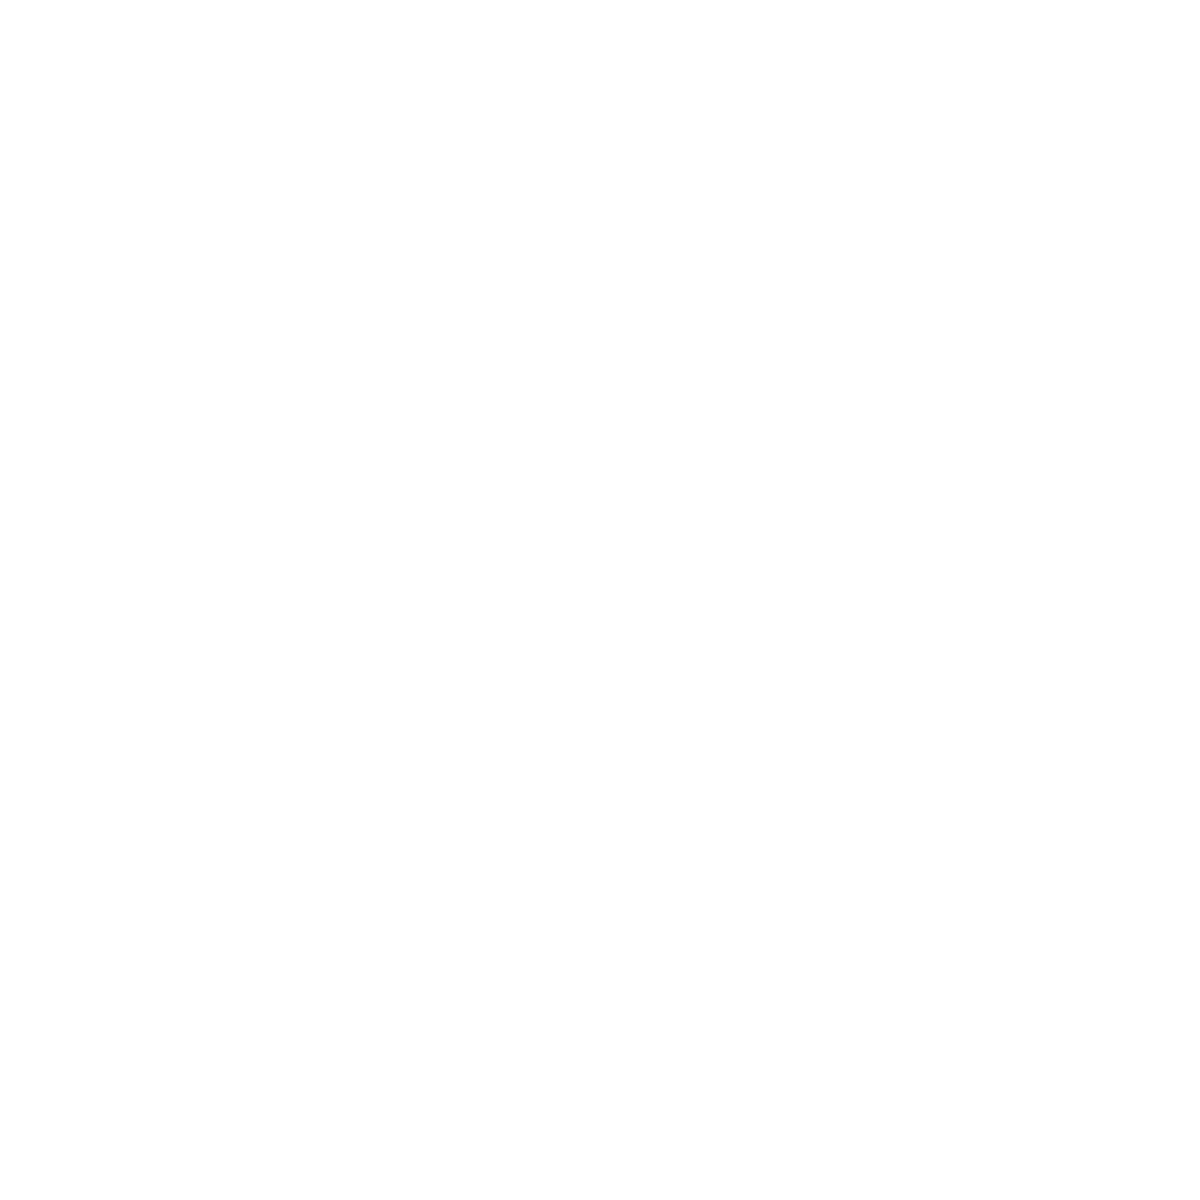

In [199]:
d   <- res1$data
idx <- res1$idx_val

tt <- d$t[idx]
yy <- res1$y[idx]

par(mfrow = c(5,1), mar = c(4,4,2,1))

## 1) AR1 vs actual
plot(tt, yy, type = "l", col = "black",
     xlab = "Time", ylab = "Power",
     main = "1-step ahead: Actual vs AR1")
lines(tt, res1$ar1_pred[idx], col = "red")
legend("topright", legend = c("Actual", "AR1 forecast"),
       col = c("black","red"), lty = 1, bty = "n")

## 1) AR4 vs actual
plot(tt, yy, type = "l", col = "black",
     xlab = "Time", ylab = "Power",
     main = "1-step ahead: Actual vs AR4")
lines(tt, res1$arp_pred[idx], col = "red")
legend("topright", legend = c("Actual", "AR4 forecast"),
       col = c("black","red"), lty = 1, bty = "n")

## 2) OLS vs actual
plot(tt, yy, type = "l", col = "black",
     xlab = "Time", ylab = "Power",
     main = "1-step ahead: Actual vs OLS")
lines(tt, res1$ols_pred[idx], col = "blue")
legend("topright", legend = c("Actual", "OLS forecast"),
       col = c("black","blue"), lty = 1, bty = "n")

## 3) RLS vs actual
plot(tt, yy, type = "l", col = "black",
     xlab = "Time", ylab = "Power",
     main = "1-step ahead: Actual vs RLS")
lines(tt, res1$rls_pred[idx], col = "darkgreen")
legend("topright", legend = c("Actual", "RLS forecast"),
       col = c("black","darkgreen"), lty = 1, bty = "n")

# EKF vs actual
plot(tt, yy, type = "l", col = "black",
     xlab = "Time", ylab = "Power",
     main = "1-step ahead: Actual vs EKF")
lines(tt, res1$ekf_pred[idx], col = "purple")
legend("topright", legend = c("Actual", "EKF forecast"),
       col = c("black","purple"), lty = 1, bty = "n")

par(mfrow = c(1,1))

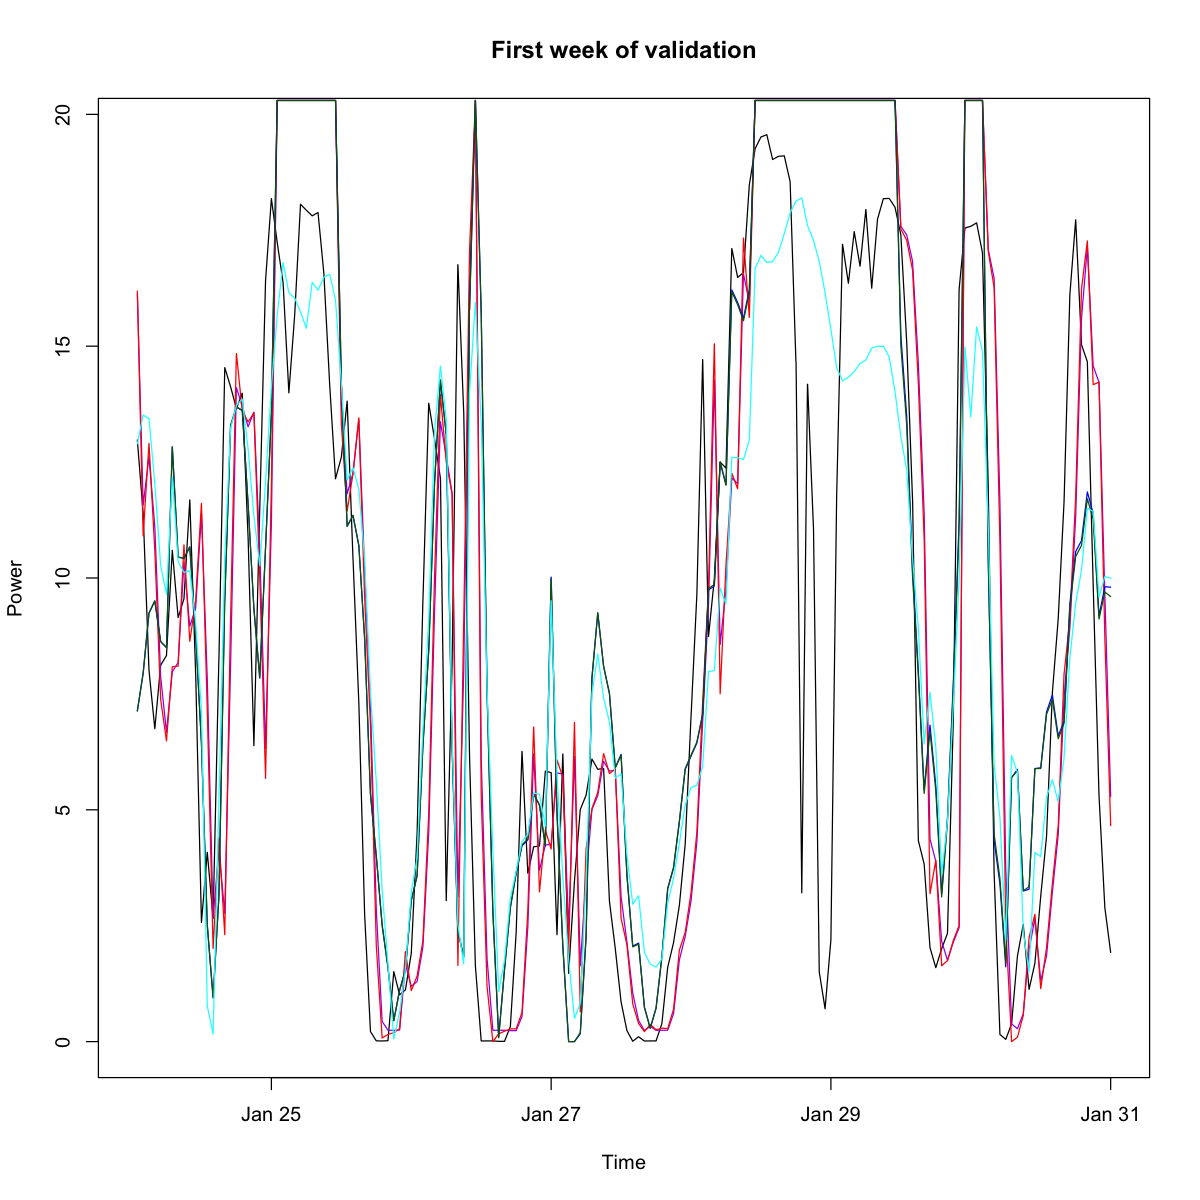

In [ ]:
k <- 24*7
plot(tt[1:k], yy[1:k], type="l", col="black", main="First week of validation",
     xlab="Time", ylab="Power")
lines(tt[1:k], res1$ar1_pred[idx][1:k],  col="purple")
lines(tt[1:k], res1$arp_pred[idx][1:k],  col="red")
lines(tt[1:k], res1$ols_pred[idx][1:k], col="blue")
lines(tt[1:k], res1$rls_pred[idx][1:k], col="darkgreen")
lines(tt[1:k], res1$ekf_pred[idx][1:k], col="cyan")

In [ ]:
plot_residual_diagnostics_vec <- function(res,
                                         fitted = NULL,
                                         model_name = "Model",
                                         width = 10,
                                         height = 10) {

  options(repr.plot.width = width, repr.plot.height = height)

  res <- na.omit(as.numeric(res))

  ## --- 6 panel layout ---
  par(mfrow = c(3, 2), mar = c(4,4,2.5,1))

  ## 1) Time Series of Residuals
  plot(res, type="l", col="steelblue",
       main=paste("Time Series of Residuals –", model_name),
       xlab="Index", ylab="Residuals")
  abline(h=0, col="black")

  ## 2) Histogram + Normal curve
  hist(res, breaks = 40, freq = FALSE,
       col = "gray80", border = "white",
       main = paste("Residual Histogram with Normal Curve –", model_name),
       xlab = "Residuals")
  curve(dnorm(x, mean = mean(res), sd = sd(res)),
        col = "red", lwd = 3, add = TRUE)

  ## 3) Normal Q–Q Plot
  qqnorm(res, main=paste("Normal Q–Q Plot –", model_name))
  qqline(res, col="red", lwd=2)

  ## 4) Cumulative Periodogram
  cpgram(res, main=paste("Cumulative Periodogram –", model_name))

  ## 5) ACF
  acf(res, main=paste("Auto-Correlation –", model_name), lwd=2)

  ## 6) PACF
  pacf(res, main=paste("Partial Auto-Correlation –", model_name), lwd=2)

  par(mfrow = c(1,1))

  ## --- Residuals vs Fitted (only if fitted provided) ---
  if (!is.null(fitted)) {
    fitted <- as.numeric(fitted)
    ok <- !is.na(fitted)
    plot(fitted[ok], res[ok],
         xlab="Fitted Values", ylab="Residuals",
         main=paste("Residuals vs Fitted Values –", model_name),
         col="steelblue", pch=16)
    abline(h = 0, col = "red", lwd = 2)
    abline(a = 0, b = -1, col = "red", lwd = 2)
  }

  invisible(NULL)
}

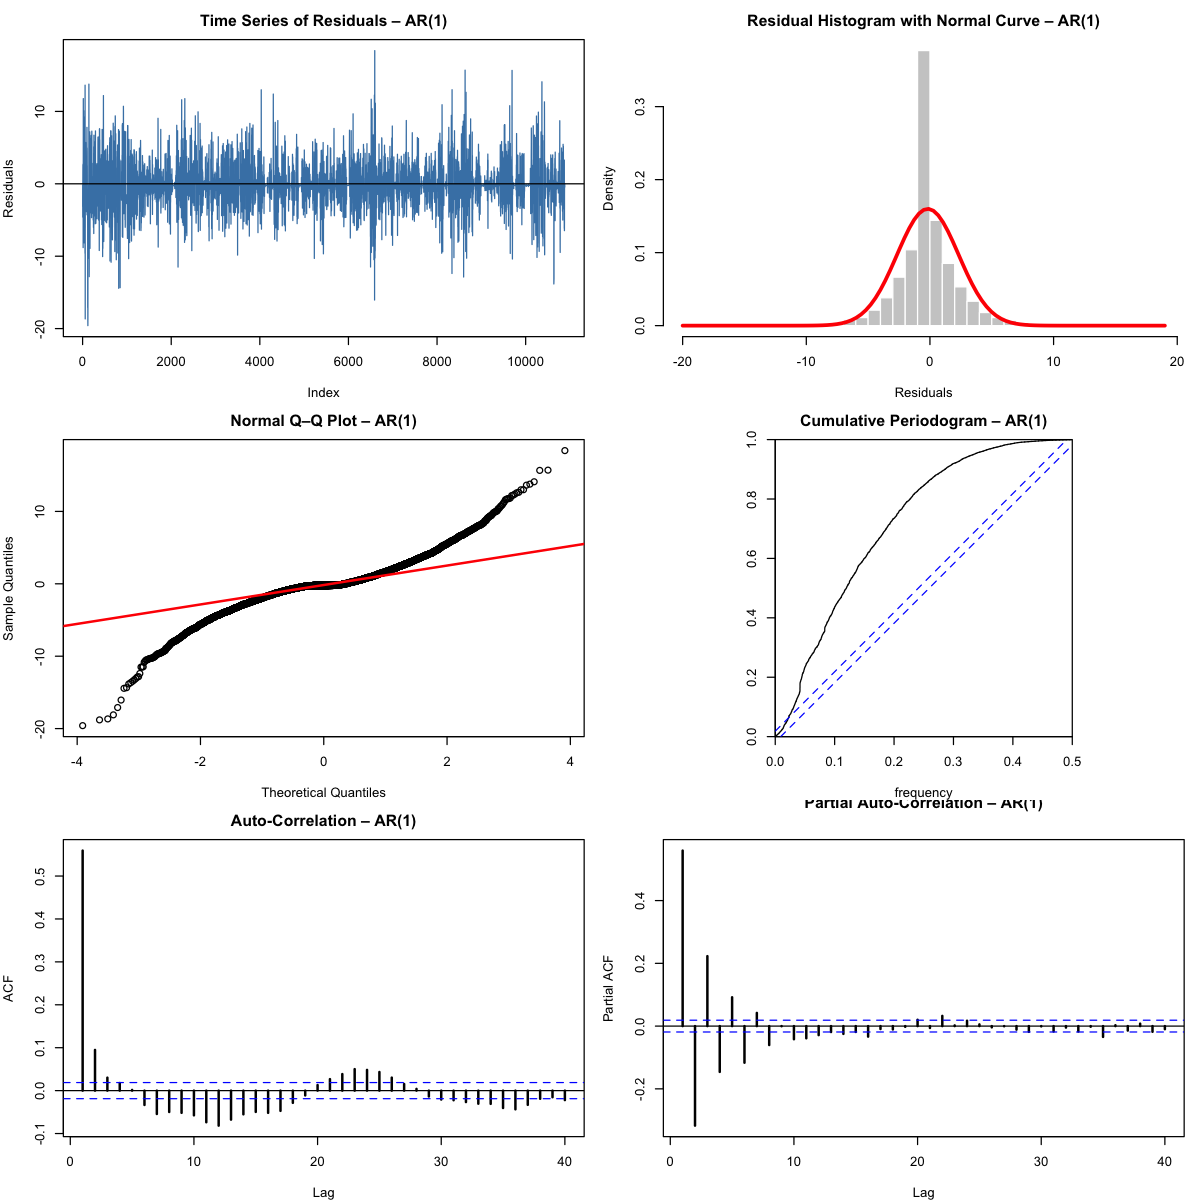

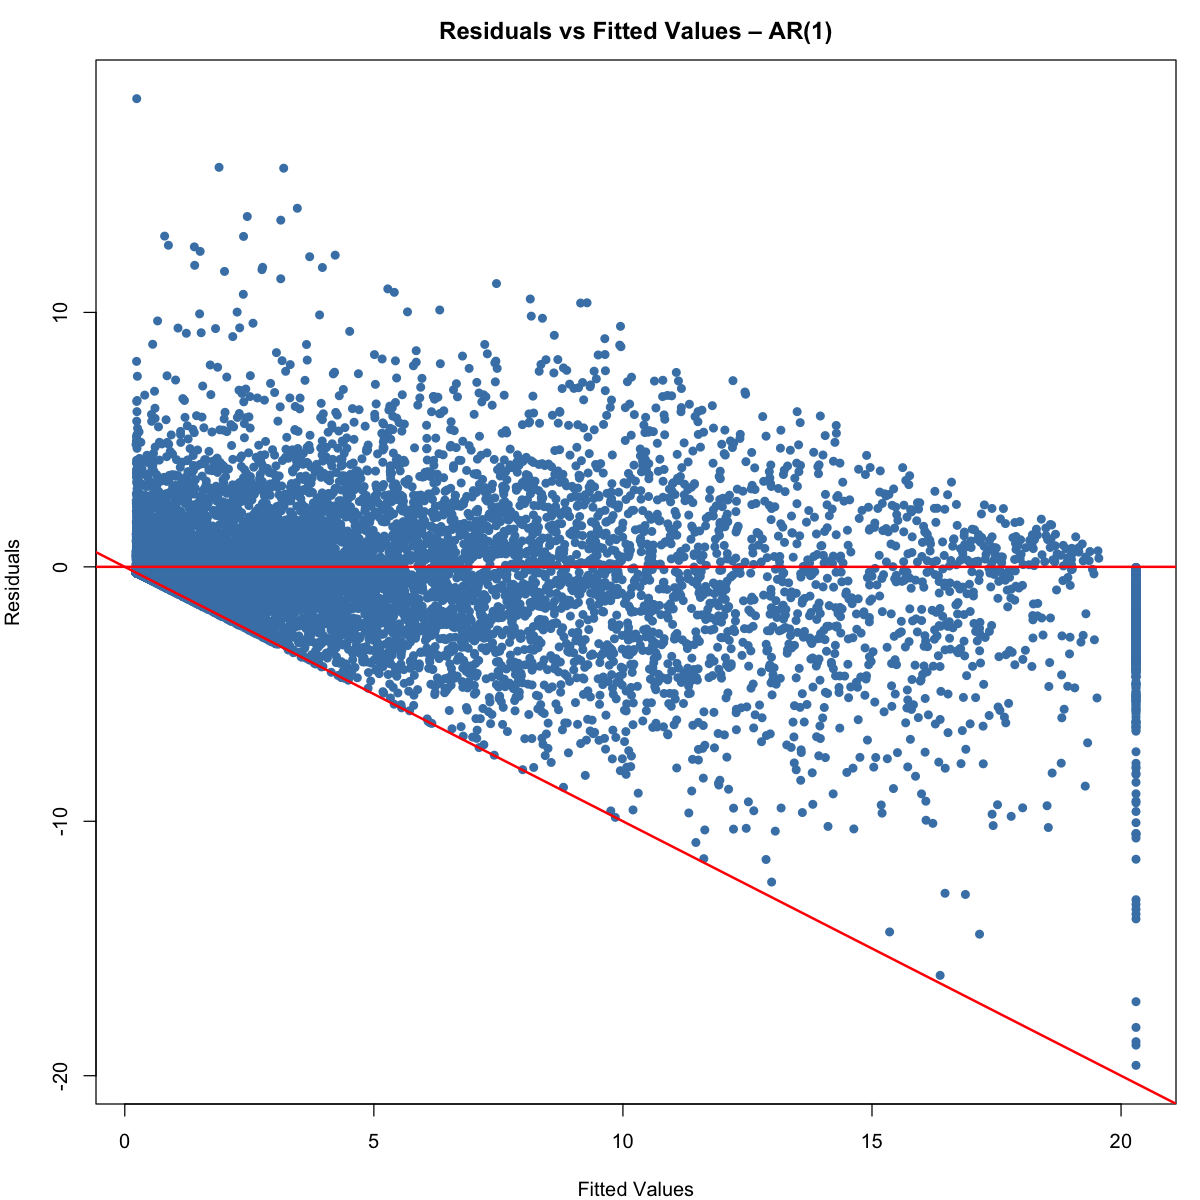

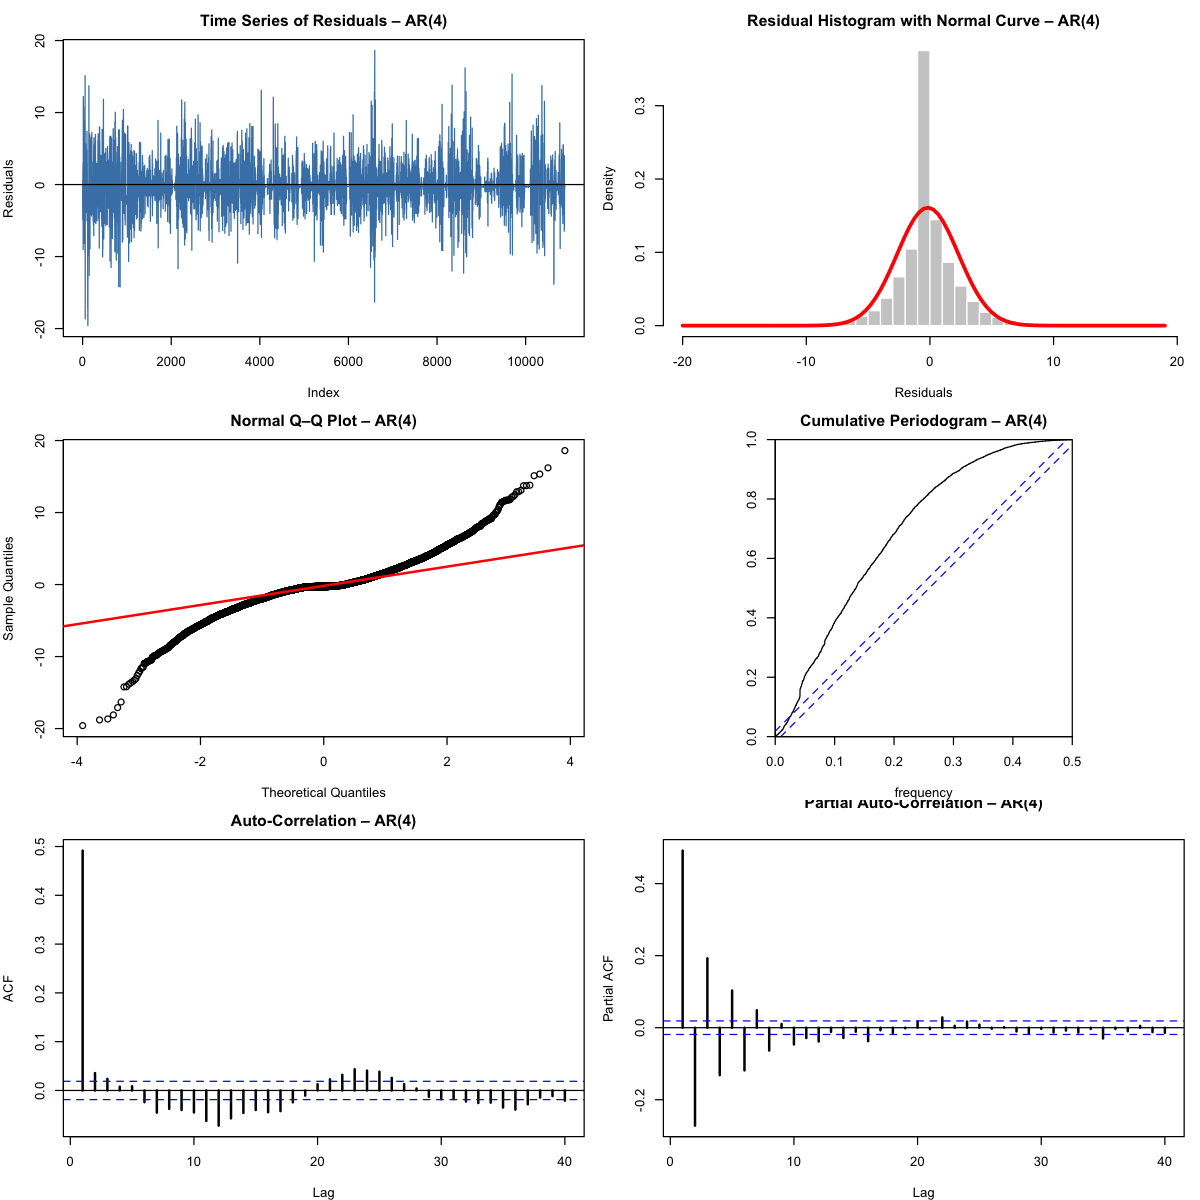

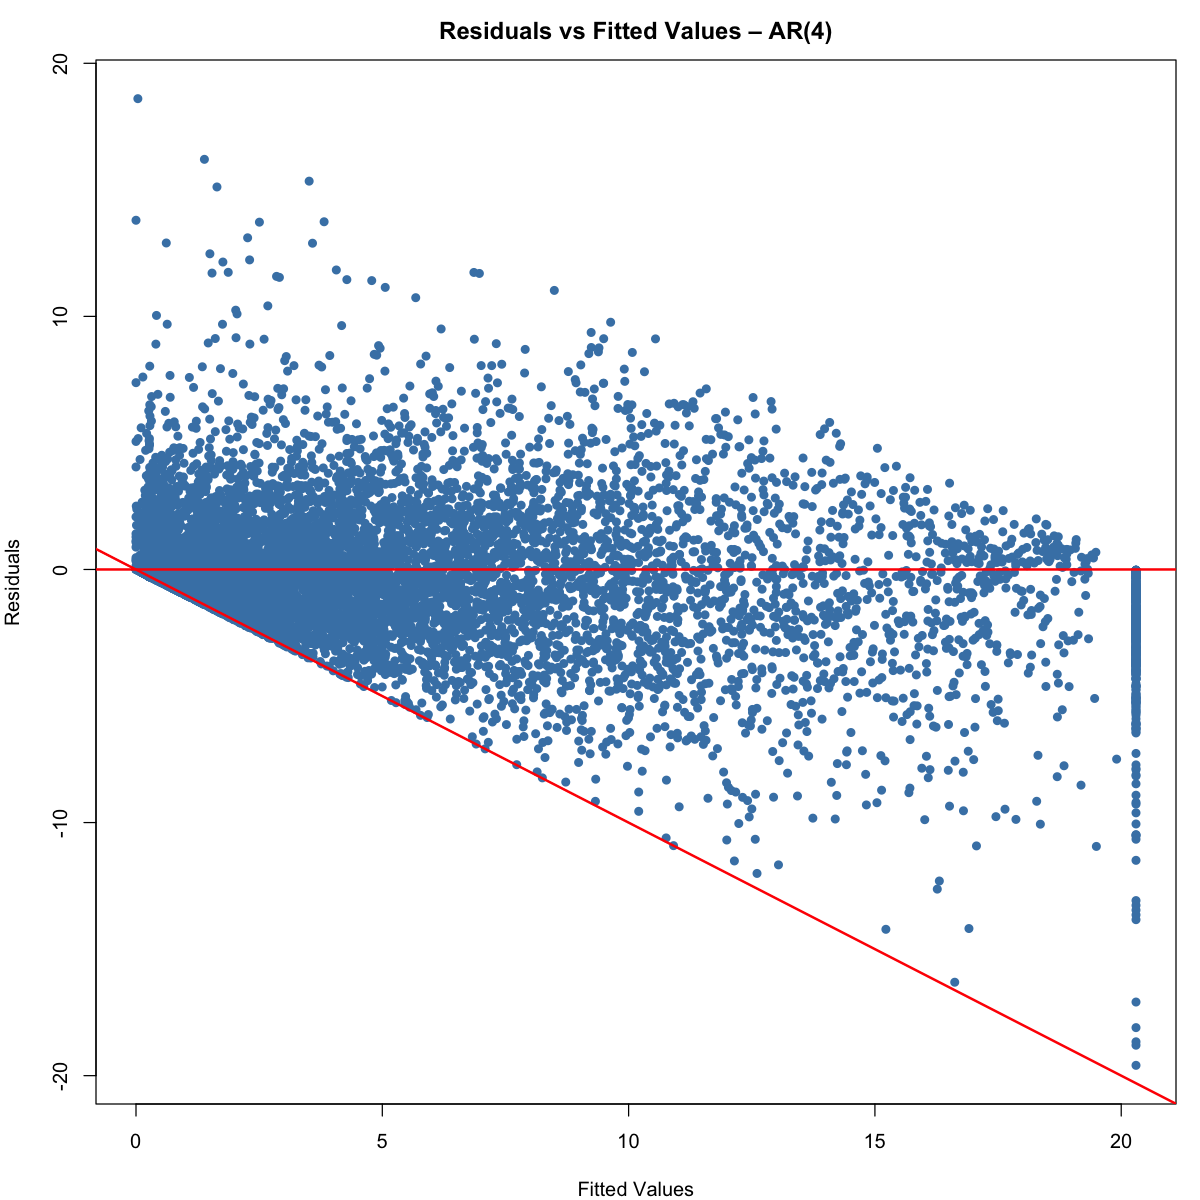

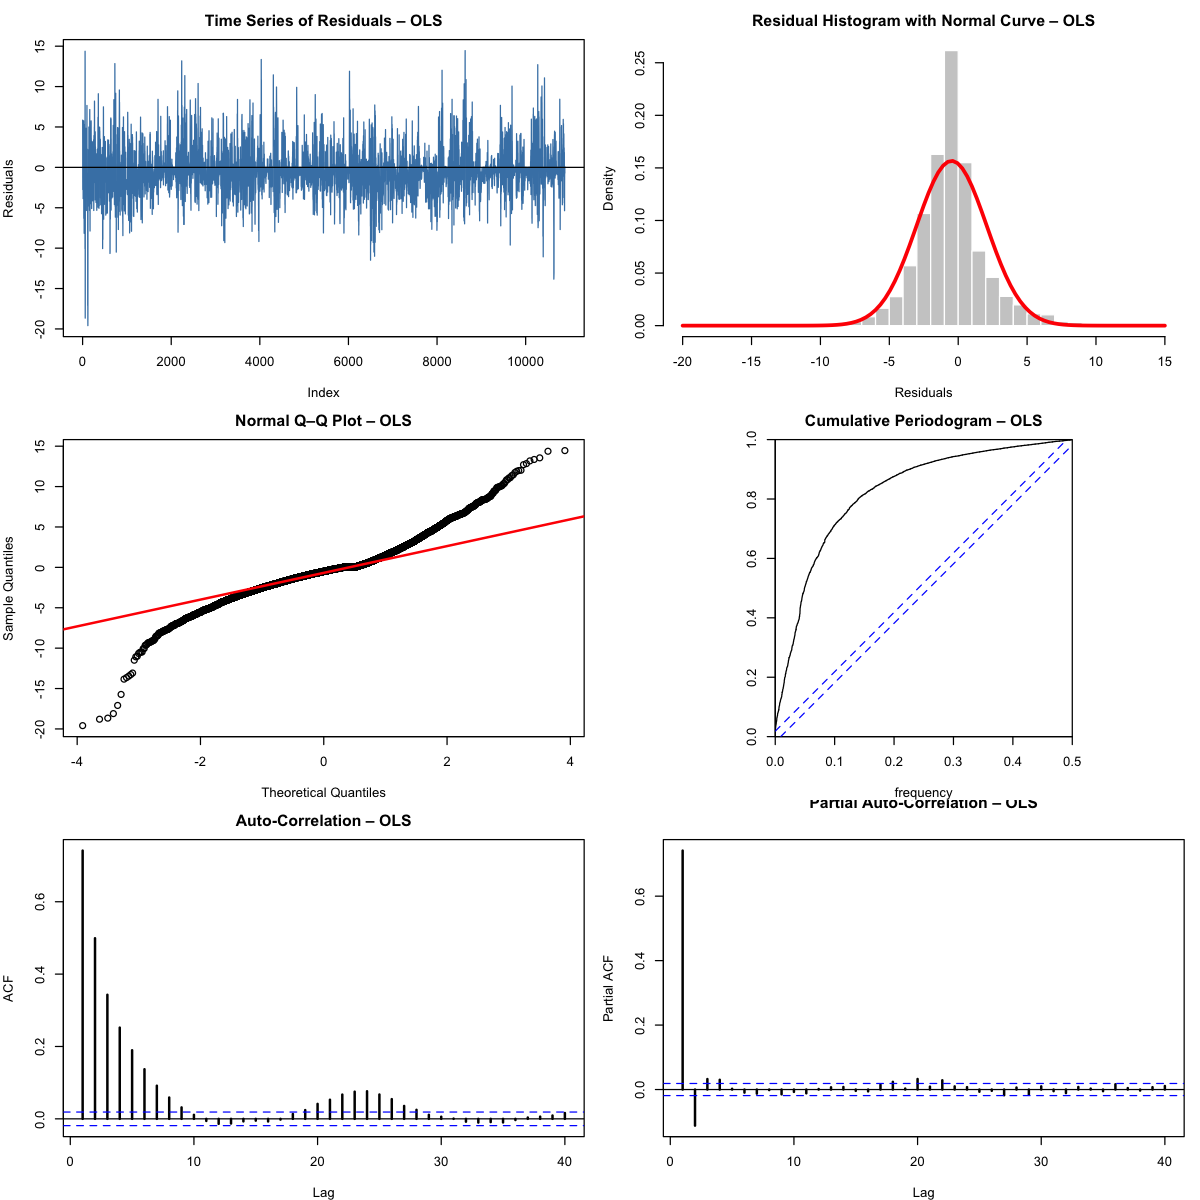

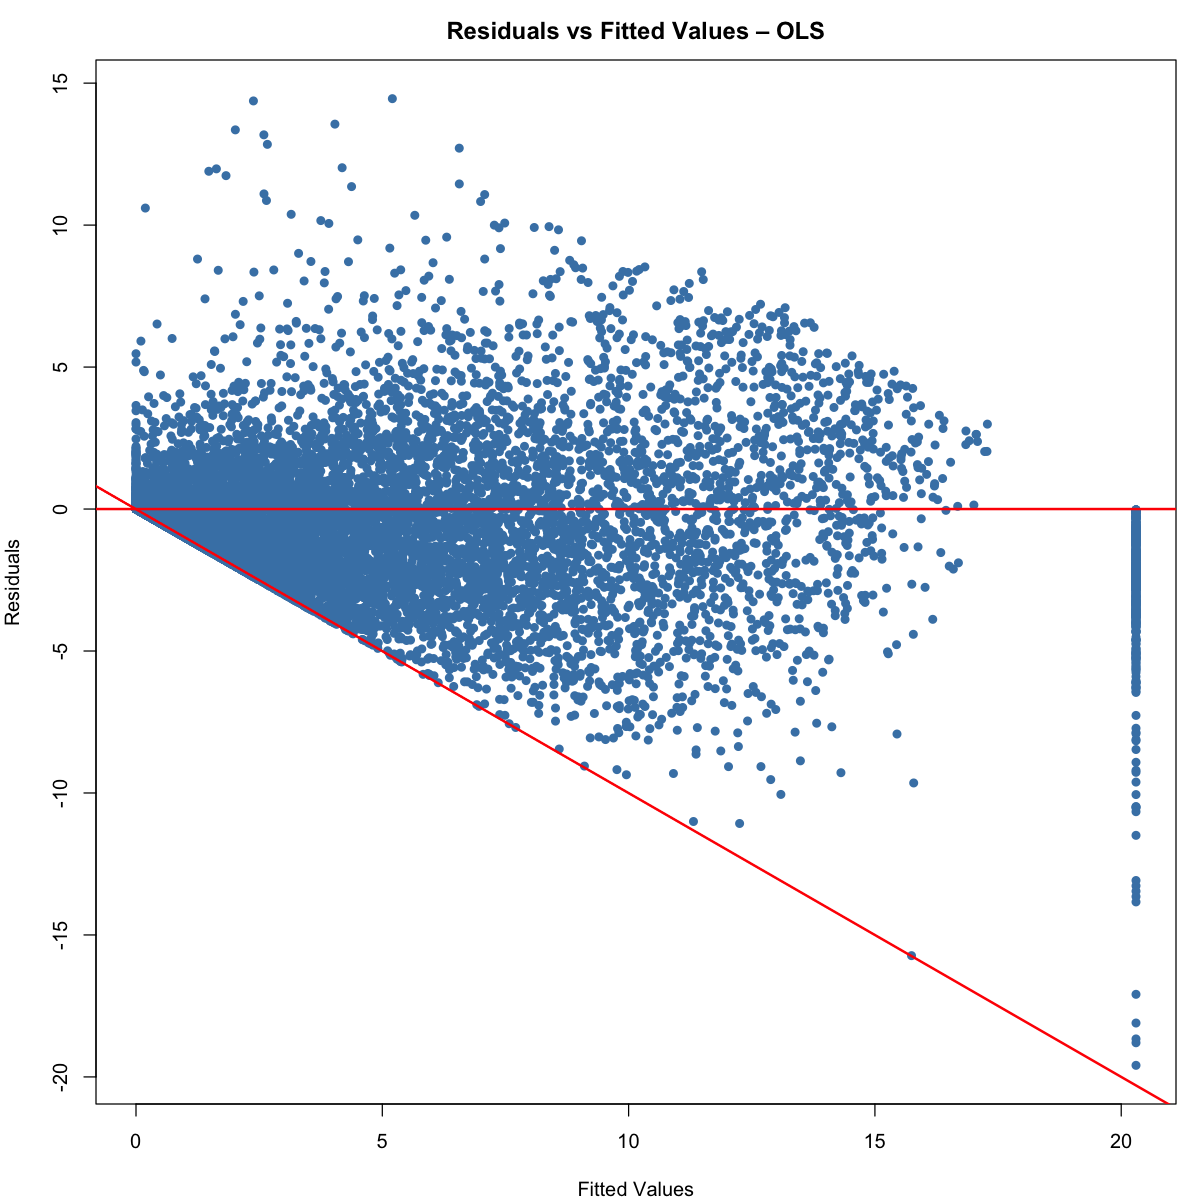

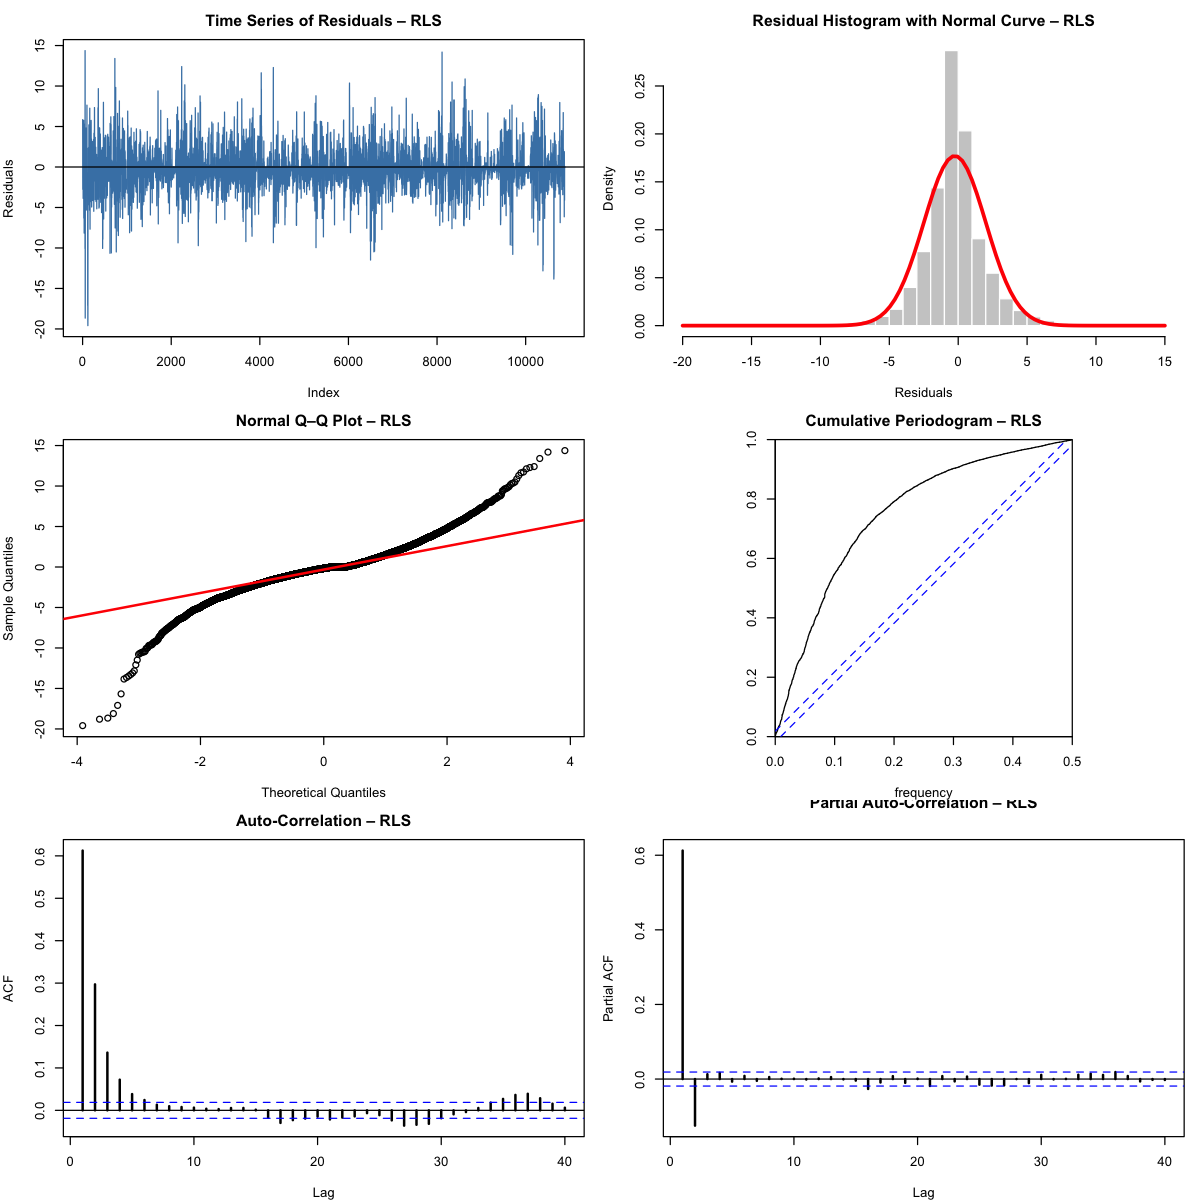

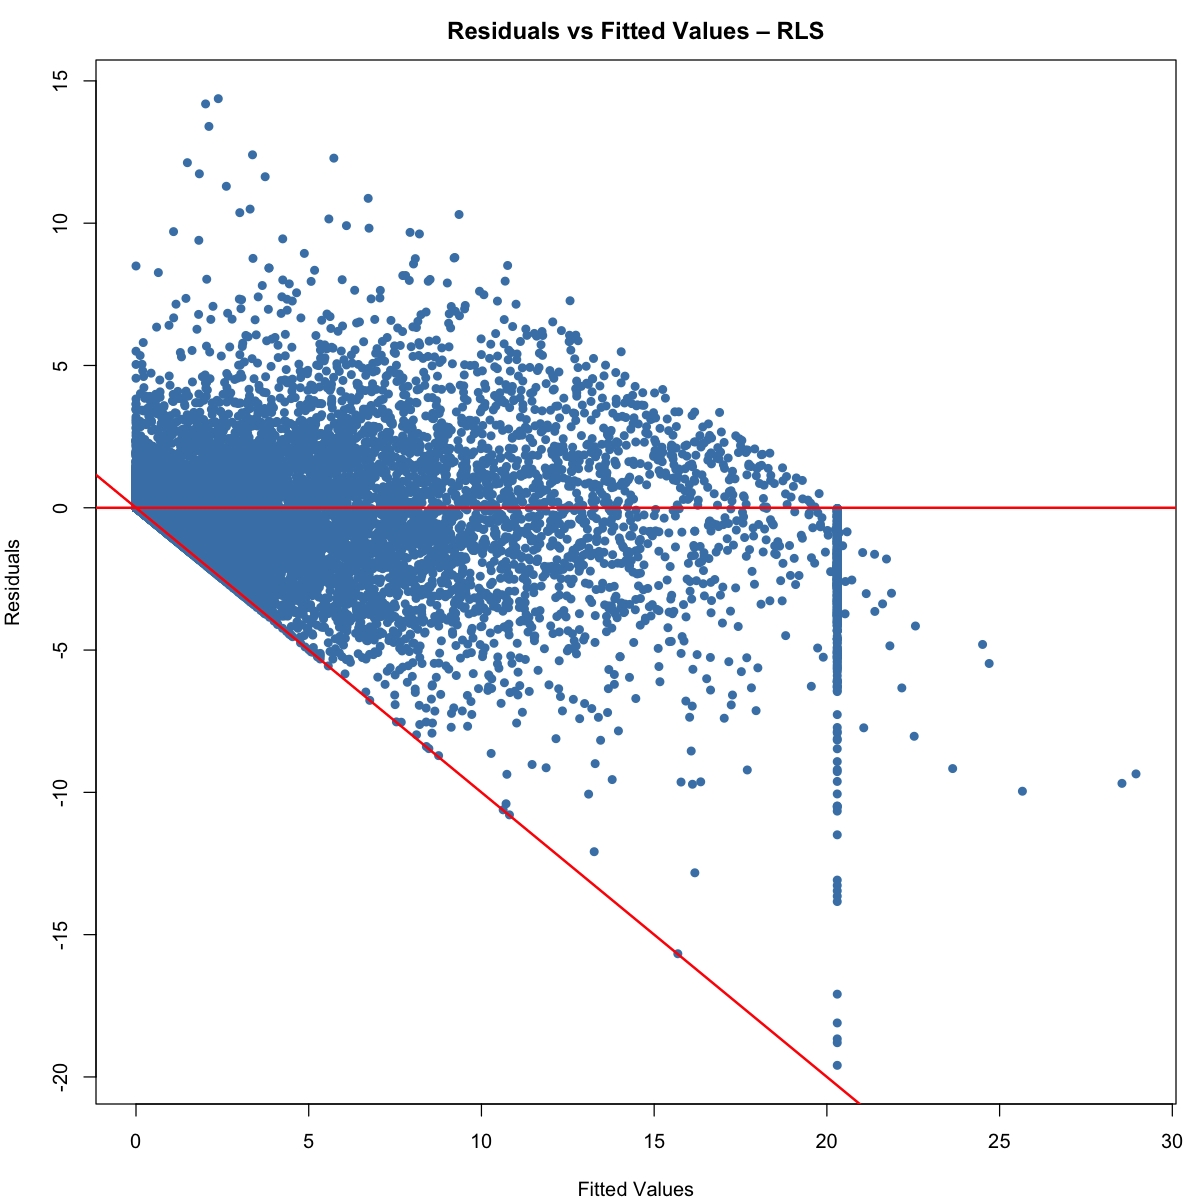

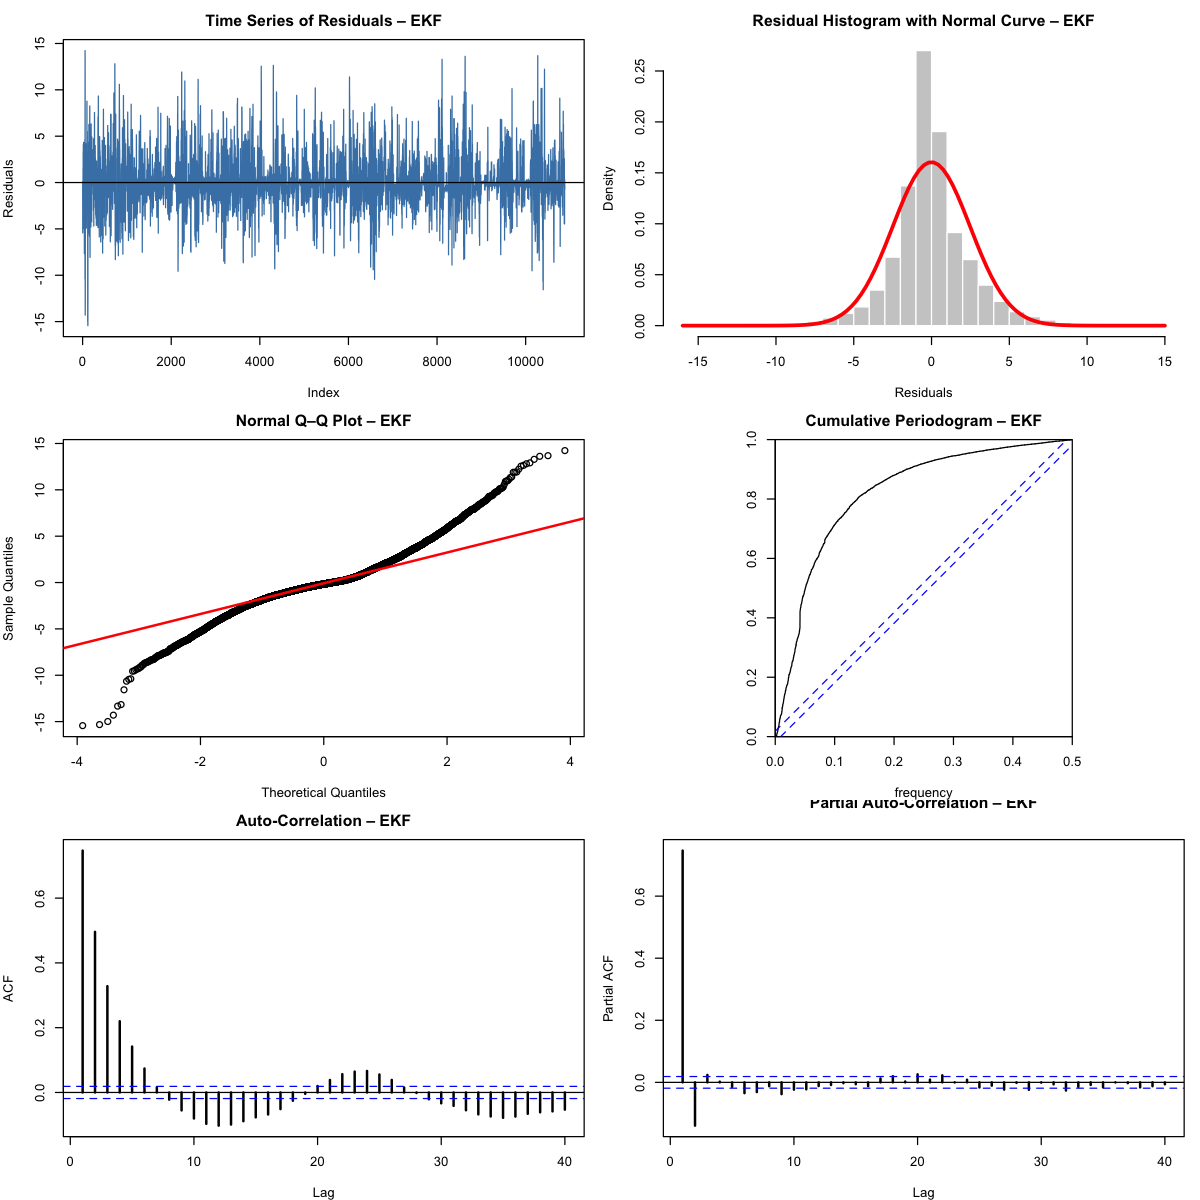

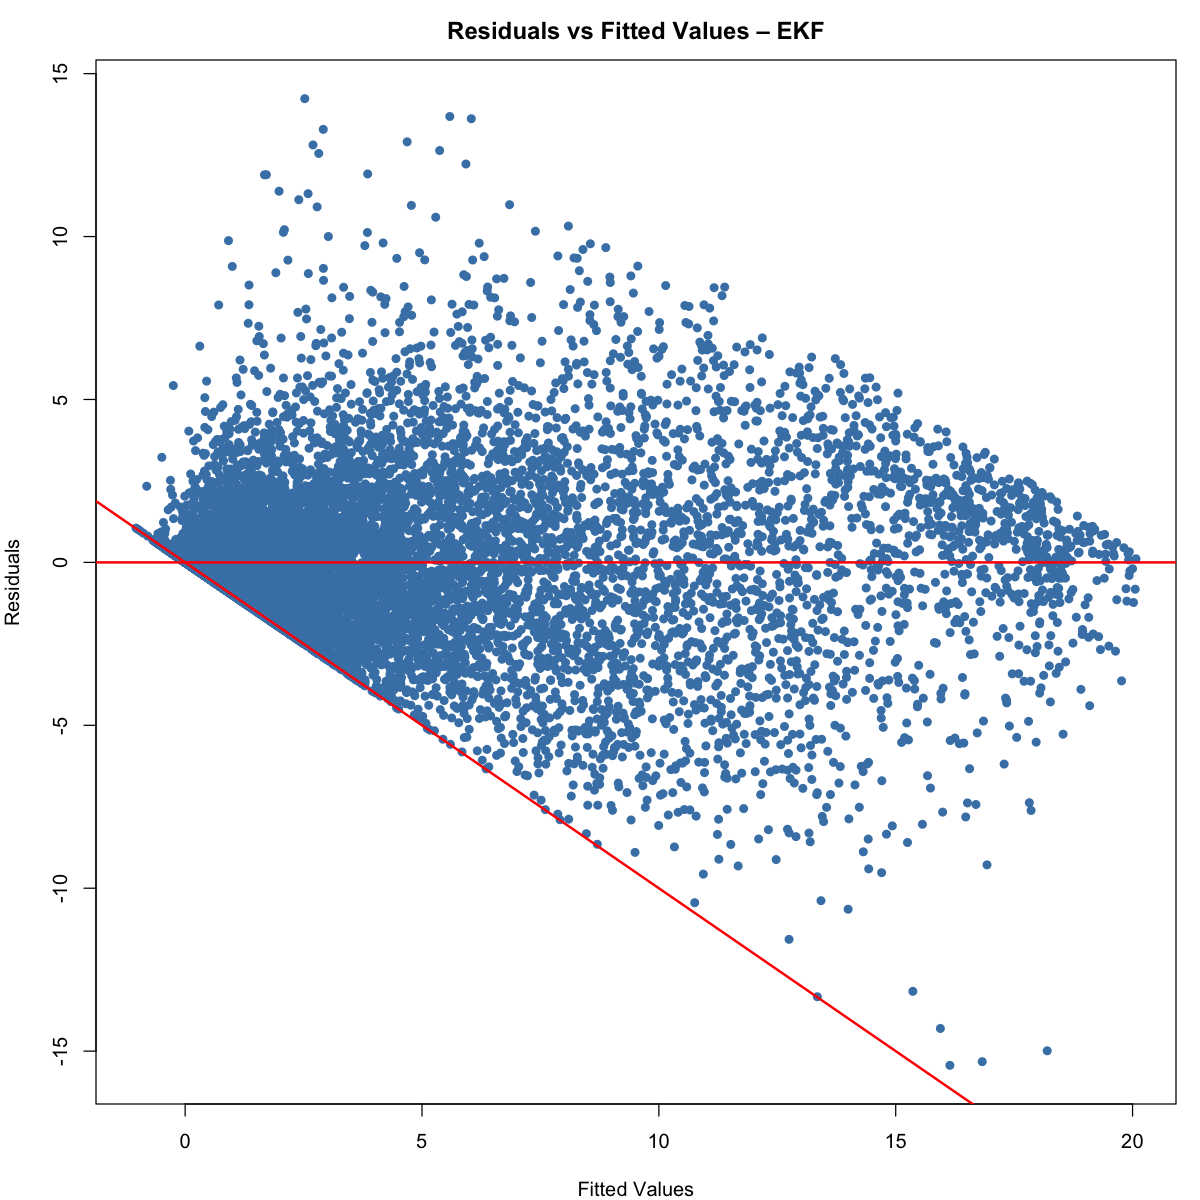

In [ ]:
idx <- res1$idx_val

# AR(1)
e_ar1   <- res1$y[idx] - res1$ar1_pred[idx]
plot_residual_diagnostics_vec(e_ar1, fitted = res1$ar1_pred[idx], model_name = "AR(1)")

# AR(p)
e_arp   <- res1$y[idx] - res1$arp_pred[idx]
plot_residual_diagnostics_vec(e_arp, fitted = res1$arp_pred[idx], model_name = paste0("AR(", ar_order, ")"))

# OLS
e_ols   <- res1$y[idx] - res1$ols_pred[idx]
plot_residual_diagnostics_vec(e_ols, fitted = res1$ols_pred[idx], model_name = "OLS")

# RLS
e_rls   <- res1$y[idx] - res1$rls_pred[idx]
plot_residual_diagnostics_vec(e_rls, fitted = res1$rls_pred[idx], model_name = "RLS")

# EKF
e_ekf   <- res1$y[idx] - res1$ekf_pred[idx]
plot_residual_diagnostics_vec(e_ekf, fitted = res1$ekf_pred[idx], model_name = "EKF")